# **Homework 5 - USA Airport Flight Analysis**

## Importing necessary libraries

In [5]:
import numpy as np 
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import functions.analysis as analysis
import functions.summarize as summarize

from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from tqdm import tqdm  

import plotly.graph_objects as go
import zipfile

In [2]:
!pip install kaggle

In [3]:
!kaggle datasets download flashgordon/usa-airport-dataset

Dataset URL: https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset
License(s): CC0-1.0
 96%|████████████████████████████████████▎ | 39.0M/40.8M [00:01<00:00, 29.8MB/s]
100%|██████████████████████████████████████| 40.8M/40.8M [00:02<00:00, 20.8MB/s]


*Unzip the file with the dataset downloaded from Kaggle:*

In [6]:
# Unzip the file we downloaded from kaggle
zip_file_path = 'usa-airport-dataset.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('.')  # Extract files to the current working directory

## 1. Flight Network Analysis (Q1)
In this task, we will analyze the **basic features** of the flight network graph, focusing on key metrics such as:  
- *Size*: The number of nodes (airports) and edges (flight connections) in the network.  
- *Density*: A measure of how interconnected the graph is.  
- *Degree Distribution*: The distribution of connections (degree) for each node in the graph.

These metrics provide insights into the structure and connectivity of the flight network.


### Basic Preprocessing and Analysis
We begin by loading the dataset and performing basic preprocessing and exploratory analysis to ensure data quality and readiness for further steps. Key tasks include:

1. *Loading the Dataset*

2. *Dataset Overview*:  
   - Use `df.info()` to inspect the structure and types of the data.  
   - Use `df.describe()` to summarize statistical details of numerical columns.  

3. *Handling Duplicates*:  
   - Check for duplicate rows in the dataset.  
   - Remove duplicates using appropriate methods.

4. *Handling Missing Values*:  
   - Identify columns with `null` or missing values.
   - Decide on strategies to handle missing data.

These steps ensure the dataset is clean and consistent before moving to deeper analysis.



In [7]:
# Loading dataset
df = pd.read_csv("Airports2.csv")
df

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3606798,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",281,969,51,119,2009-02-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606799,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",245,1026,54,119,2009-11-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606800,STL,TBN,"St. Louis, MO","Fort Leonard Wood, MO",363,1273,67,119,2009-08-01,2828990,46457,38.748699,-90.370003,37.741600,-92.140701
3606801,CGI,TBN,"Cape Girardeau, MO","Fort Leonard Wood, MO",2,19,1,146,2009-08-01,93712,46457,37.225300,-89.570801,37.741600,-92.140701


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


In [5]:
df.describe()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
count,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.606803e+06,3.599849e+06,3.599849e+06,3.599996e+06,3.599996e+06
mean,2.688910e+03,4.048297e+03,3.722890e+01,6.973190e+02,5.871502e+06,5.897982e+06,3.775029e+01,-9.186178e+01,3.774091e+01,-9.183433e+01
std,4.347617e+03,6.200871e+03,4.961970e+01,6.044165e+02,7.858062e+06,7.906127e+06,5.765453e+00,1.653773e+01,5.736556e+00,1.647228e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.300500e+04,1.288700e+04,1.972140e+01,-1.579220e+02,1.972140e+01,-1.579220e+02
25%,1.090000e+02,1.560000e+02,2.000000e+00,2.730000e+02,1.030597e+06,1.025470e+06,3.363670e+01,-9.703800e+01,3.363670e+01,-9.703800e+01
50%,1.118000e+03,1.998000e+03,2.500000e+01,5.190000e+02,2.400193e+06,2.400193e+06,3.885210e+01,-8.775240e+01,3.885210e+01,-8.775240e+01
75%,3.503000e+03,5.370000e+03,5.500000e+01,9.270000e+02,8.613622e+06,8.635706e+06,4.173260e+01,-8.029060e+01,4.173260e+01,-8.029060e+01
max,8.959700e+04,1.470620e+05,1.128000e+03,5.095000e+03,3.813959e+07,3.813959e+07,6.483750e+01,-6.882810e+01,6.483750e+01,-6.882810e+01


In [8]:
# Checking for duplicates
df.duplicated().sum()

np.int64(41753)

In [9]:
# Dropping duplicates
df = df.drop_duplicates()

In [10]:
# Checking for null values
df.isnull().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6584
Org_airport_long          6584
Dest_airport_lat          6495
Dest_airport_long         6495
dtype: int64

#### Filling Missing Coordinates for Airports

This step involves addressing missing latitude and longitude coordinates for airports, as these are critical for spatial and network analyses. The process includes:

1. **Identifying Missing Coordinates**:  
   - Locate rows with missing latitude or longitude values.  

2. **Filling Missing Data**:  
   - Use external data sources or APIs to retrieve the missing coordinates based on airport names and locations.  
   - Alternatively, use reference datasets or manual inputs to fill the missing values.  

3. **Verifying Completeness**:  
   - After filling in the missing data, recheck the dataset to ensure no coordinates are missing.

This step ensures the dataset is complete and ready for accurate network analysis.


In [9]:
# Get the unique origin airports with their coordinates
df1 = df[['Origin_airport', 'Org_airport_lat', 'Org_airport_long']].rename(
        columns={'Origin_airport': 'airport_id', 'Org_airport_lat': 'latitude', 'Org_airport_long': 'longitude'})

# Get the unique destination airports with their coordinates 
df2 = df[['Destination_airport', 'Dest_airport_lat', 'Dest_airport_long']].rename(
    columns={'Destination_airport': 'airport_id', 'Dest_airport_lat': 'latitude', 'Dest_airport_long': 'longitude'})

# Concatenate them and drop duplicates 
stacked_coords = pd.concat([df1, df2])
stacked_coords = stacked_coords.drop_duplicates()

# Keep airports that have missing coordinates
stacked_coords = stacked_coords[stacked_coords['latitude'].isna() | stacked_coords['longitude'].isna()]

print(stacked_coords)



        airport_id  latitude  longitude
945            RBG       NaN        NaN
1288           DQF       NaN        NaN
8537           PRB       NaN        NaN
9626           PNC       NaN        NaN
9643           WDG       NaN        NaN
...            ...       ...        ...
3307036        MIW       NaN        NaN
3472388        JCC       NaN        NaN
3488603        NGP       NaN        NaN
3494630        MPS       NaN        NaN
3606576        PHD       NaN        NaN

[243 rows x 3 columns]


In [10]:
# Initialize geolocator (one-time setup)
geolocator = Nominatim(user_agent="airport_coordinates")

# Dictionary to store airport coordinates (avoid redundant API calls)
coords_cache = {}

# Function to get coordinates if they are missing
def get_coordinates(airport_code, retries=3, delay=2):
    if airport_code in coords_cache:
        return coords_cache[airport_code]
    
    # Attempt to geocode with retries in case of timeout
    for _ in range(retries):
        try:
            location = geolocator.geocode(f"{airport_code} Airport", country_codes="US", timeout=10)
            if location:
                coords_cache[airport_code] = (location.latitude, location.longitude)
                return location.latitude, location.longitude
            else:
                return None, None  
        except GeocoderTimedOut:
            print(f"Timeout error while fetching {airport_code}, retrying...")
            # Wait before retrying
            time.sleep(delay)
        except Exception as e:
            print(f"Error fetching {airport_code}: {e}")
            break
    # Return None if all retries fail
    return None, None  

# Use tqdm to track progress
for index, row in tqdm(stacked_coords.iterrows(), total=stacked_coords.shape[0], desc="Geocoding airports"):
    if pd.isna(row["latitude"]) or pd.isna(row["longitude"]):
        lat, lon = get_coordinates(row["airport_id"])
        stacked_coords.at[index, "latitude"] = lat if pd.isna(row["latitude"]) else row["latitude"]
        stacked_coords.at[index, "longitude"] = lon if pd.isna(row["longitude"]) else row["longitude"]

# Display the updated stacked_coords DataFrame
print(stacked_coords)

Geocoding airports: 100%|██████████| 243/243 [04:02<00:00,  1.00it/s]

        airport_id   latitude   longitude
945            RBG  43.239865 -123.357144
1288           DQF        NaN         NaN
8537           PRB  35.675641 -120.630626
9626           PNC  36.731404  -97.099031
9643           WDG  36.375431  -97.787126
...            ...        ...         ...
3307036        MIW  42.112129  -92.917025
3472388        JCC        NaN         NaN
3488603        NGP  27.692197  -97.276022
3494630        MPS  33.097345  -94.963060
3606576        PHD  40.471303  -81.419407

[243 rows x 3 columns]


In [11]:
# After that process get missing airports coordinates again
missing_airports = stacked_coords[stacked_coords['latitude'].isna() | stacked_coords['longitude'].isna()]
# Show the count
print(missing_airports.shape)

missing_airports_list = list(missing_airports['airport_id'])

# Drop rows where 'Name' is in missing airports list
to_drop = stacked_coords[stacked_coords['airport_id'].isin(missing_airports_list)].index
stacked_coords = stacked_coords.drop(to_drop, axis=0)

# Create a single dictionary with airport_id as keys and (latitude, longitude) as values (tuples) that has no missing
# values
airport_coords = dict(zip(stacked_coords['airport_id'], zip(stacked_coords['latitude'], stacked_coords['longitude'])))


(53, 3)


In [12]:
# Ask Chatgpt for the missing coordinates using this source
# https://gist.github.com/Echo226/c2fba4e7edf964ccfcfa8de919aaad98

airports = {
    "DQF": (33.30777777, -111.65555555),   # Williams Gateway, AZ, USA
    "KY5": (37.35583333, -87.39833333), # Madisonville, KY, USA
    "HIK": (21.316, -157.917),  # Hickam AFB, Hawaii, USA
    "ESF": (31.394444, -92.295833),  # Esler Field, Louisiana, USA
    "VWL": (47.37527778, -94.79861111), # Nary National Shefland Field   Bemidji, MN, USA
    "XXW": (30.1814, -82.6346), # Lake City Municipal Airport in Lake City, Florida, USA
    "FVS": (43.83388889, -111.805), # Rexburg-Madison County	Rexburg, ID, USA
    "HLM": (42.7953, -86.1628),  # Park Township Airport, Michigan, USA
    "JSE": (58.30166667, -134.42444444), # Juneau Seaplane Base	Juneau, AK, USA
    "TN6": (35.99805556, -89.40666667), # Dyersburg Regional Dyersburg, TN, USA
    "AIY": (39.3601, -74.4567),  # Atlantic City Municipal, NJ, USA
    "JRA": (40.750, -74.007),  # West 30th Street Heliport, NYC, USA
    "JRB": (40.7012, -74.009),  # Downtown Manhattan/Wall Street Heliport, NYC, USA
    "TSS": (40.7425, -73.97222222), # East 34th Street Heliport	New York, NY
    "WQM": (30.1261, -93.2128), # Chennault International Airport, Lake Charles, Louisiana, USA
    "KY1": (37.5775, -84.76944444), # Stuart Powell Field	Danville, KY, USA
    "IN1": (41.30722222, -85.06444444), # De Kalb County	Auburn, IN, USA
    "TN3": (35.50694444, -86.80388889), # Ellington Lewisburg, TN, USA
    "OH5": (39.24666667, -84.38888889), # Cincinnati - Blue Ash Cincinnati, OH, USA
    "KY3": (38.05805556, -83.97944444), # Mount Sterling Montgomery County	Mount Sterling, KY, USA
    "OH3": (39.44055556, -83.02305556), # Ross County	Chillicothe, OH, USA
    "VWT": (32.11083333, -84.18888889), # Jimmy Carter Regional Americus, GA, USA
    "WV1": (38.29444444, -81.56555556),   # Mcs-Pad Heliport Charleston, WV, USA
    "OH2": (40.37222222, -83.81916667), # Bellefontaine Regional	Bellefontaine, OH, USA
    "VWH": (31.92138889, -102.38722222), # Odessa Schlemeyer Field Midland/Odessa, TX, USA
    "MI2": (42.74277778, -86.10777778), # West Michigan Regional	Holland, MI, USA
    "VWD": (36.31666667, -119.62777778), # Hanford Municipal Hanford, CA, USA
    "NY3": (42.45, -75.01638889), # F and F Airpark Inc Oneonta, NY, USA
    "LSD": (37.0827, -84.0847),  # Creech AAF, KY, USA
    "DQU": (55.77888889, -131.60138889), # Neets Bay Ketchikan, AK, USA
    "LWF": (35.23444444, -87.25805556), # Lawrenceburg-Lawrence County	Lawrenceburg, TN, USA
    "JZU": (42.89111111, -73.24611111), # William H. Morse State Bennington, VT, USA
    "STF": (33.43305556, -88.84861111), # George M. Bryan	Starkville, MS, USA
    "TX6": (30.52694444, -98.35888889), # Horseshoe Bay Resort	Horseshoe Bay, TX, USA
    "OH1": (39.57027778, -83.42055556), # Fayette County Washington Court House, OH, USA
    "DQC": (27.81333333, -80.49555556), # Sebastian Municipal	Sebastian, FL, USA
    "CGX": (41.858, -87.607),  # Meigs Field, IL, USA (now closed)
    "AWX": (32.33083333, -102.52972222), # Andrews County Andrews, TX, USA
    "LJY": (37.64833333, -92.6525), # Floyd W Jones Lebanon, Lebanon, MO, USA
    "UXJ": (37.63166667, -84.3325), # Central Kentucky Regional, Richmond, KY, USA
    "XWL": (43.20916667, -112.34972222), # McCarley Field, Blackfoot, ID, USA
    "ZXX": (46.21861111, -119.21), # Vista Field	Kennewick, WA, USA
    "NZJ": (33.6757, -117.7318),  # MCAS El Toro, CA, USA (closed)
    "JCC": (37.7697, -122.3937),  # China Basin Heliport, SF, USA
    "UCA": (43.1451, -75.3836),  # Oneida County Airport, Utica, New York, USA
    "BGS": (32.2126, -101.5210), # Webb Air Force Base, Big Spring, Texas, USA
    "MQJ": (39.8439, -85.8971),  # Mount Comfort Airport, Indianapolis, Indiana, USA
    "NZC": (30.2188, -81.8765), # Naval Air Station Cecil Field, USA
    "CHI": (41.87388889, -87.75555556), # Chicago Metropolitan Area	Chicago, IL, USA
    "BSM": (30.19472222, -97.67666667), # Bergstrom AFB	Austin, TX, USA
    "WTC": (40.7125, -74.015), # World Trade Center Heliport New York, NY, USA
    "ULS": (37.60388889, -101.37361111), # Ulysses Airport, Ulysses, KS, USA
    "JWN": (36.1821, -86.8867) # John C. Tune Airport, Nashville, Tennessee, USA
}

# Creating full dictionary with all the missing airport's coordinates
airport_coords = airport_coords | airports
# quick check TODO TO REMOVE 
print(len(airport_coords))

243


In [ ]:
# Fill missing values for origin airports using the dictionary
df['Org_airport_lat'] = df['Org_airport_lat'].fillna(df['Origin_airport'].map(lambda x: airport_coords.get(x, (None, None))[0]))
df['Org_airport_long'] = df['Org_airport_long'].fillna(df['Origin_airport'].map(lambda x: airport_coords.get(x, (None, None))[1]))

# Fill missing values for destination airports using the dictionary
df['Dest_airport_lat'] = df['Dest_airport_lat'].fillna(df['Destination_airport'].map(lambda x: airport_coords.get(x, (None, None))[0]))
df['Dest_airport_long'] = df['Dest_airport_long'].fillna(df['Destination_airport'].map(lambda x: airport_coords.get(x, (None, None))[1]))

In [14]:
# Performing checks to make sure everything went well
# TODO MAYBE REMOVE IT LATER
print(df.shape)
print(df.isnull().sum())

(3565050, 15)
Origin_airport            0
Destination_airport       0
Origin_city               0
Destination_city          0
Passengers                0
Seats                     0
Flights                   0
Distance                  0
Fly_date                  0
Origin_population         0
Destination_population    0
Org_airport_lat           0
Org_airport_long          0
Dest_airport_lat          0
Dest_airport_long         0
dtype: int64


### 1.1 Computing function

In [11]:
# Creating the flight network graph
flight_network = nx.DiGraph()
for _, row in df.iterrows():
    flight_network.add_edge(row['Origin_airport'], row['Destination_airport'])

In [16]:
# Avoiding long output for now
# TODO MAYBE REMOVE IT COMPLETLY AS IT IS USED IN THE NEXT FUNCTION TO SUMMARIZE 
# analysis.analyse_graph_features(flight_network)

### 1.2 Summarizing function

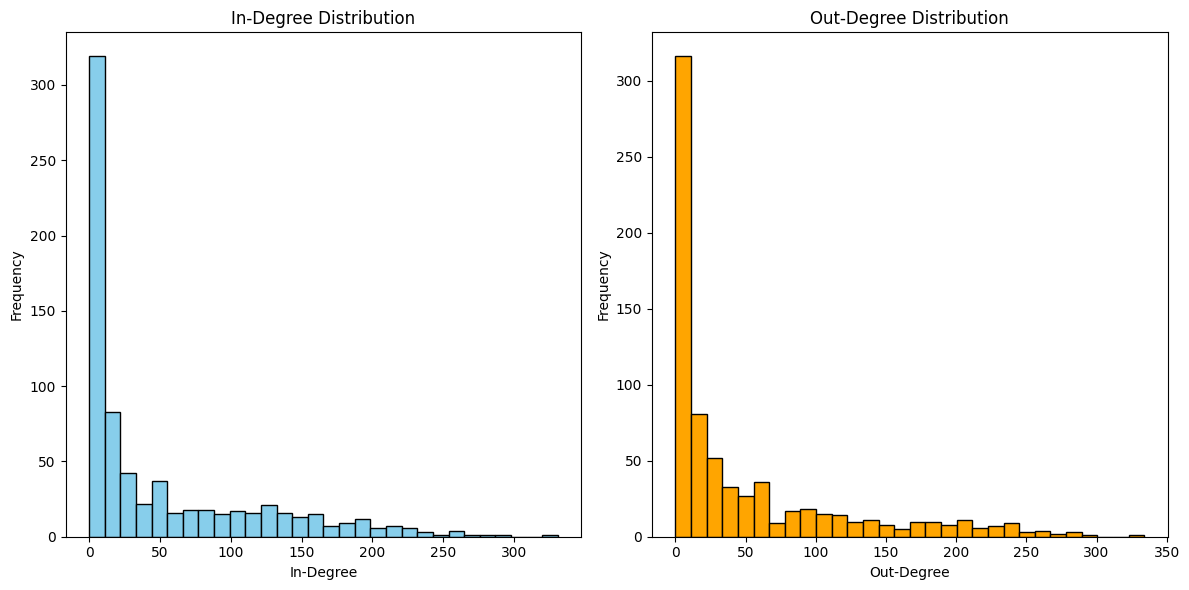

Graph Summary Report:
Number of airports (nodes): 727
Number of flights (edges): 36719
Graph Density: 0.1391
Graph Type: Dense

Identified Hubs (Airports with high degree):
   Node  In-Degree  Out-Degree  Total Degree
0   HOU        164         175           339
1   IND        255         258           513
2   IAD        230         251           481
3   LAS        227         247           474
4   MSP        291         292           583
..  ...        ...         ...           ...
73  MEM        277         287           564
74  DAY        186         206           392
75  GRR        152         175           327
76  TPA        161         191           352
77  BNA        221         220           441

[78 rows x 4 columns]


In [17]:
summarize.summarize_graph_features(flight_network)

### 1.3 Deeper analysis

In [18]:
total_passengers = (df.groupby(['Origin_city', 'Destination_city'])['Passengers'].sum()
                    .reset_index().rename(columns={"Passengers": "Total_passengers"}))
total_passengers_df = total_passengers[['Origin_city', 'Destination_city', 'Total_passengers']]

In [19]:
total_passengers_df

,Origin_city,Destination_city,Total_passengers
0,"Aberdeen, SD","Anchorage, AK",2
1,"Aberdeen, SD","Billings, MT",100
2,"Aberdeen, SD","Bismarck, ND",67
3,"Aberdeen, SD","Brainerd, MN",32
4,"Aberdeen, SD","Eau Claire, WI",32
...,...,...,...
30326,"Yuma, AZ","Yuma, AZ",0
30327,"Zanesville, OH","Atlanta, GA",0
30328,"Zanesville, OH","Detroit, MI",0
30329,"Zanesville, OH","Kansas City, MO",0


In [20]:
# Sorting to find busiest routes by passengers flow
busiest_routes = total_passengers.sort_values(by='Total_passengers', ascending=False)
busiest_routes = busiest_routes.head(20)

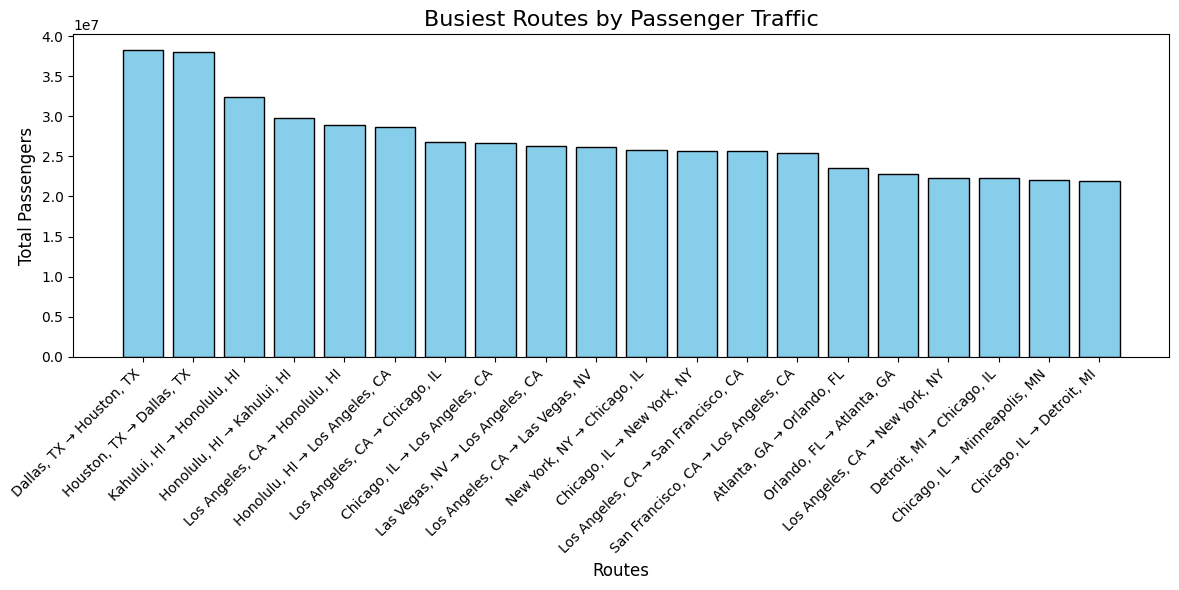

In [21]:
# Visualise the results
plt.figure(figsize=(12, 6))
plt.bar(
    busiest_routes["Origin_city"] + " → " + busiest_routes["Destination_city"],
    busiest_routes["Total_passengers"],
    color="skyblue",
    edgecolor="black"
)

plt.title("Busiest Routes by Passenger Traffic", fontsize=16)
plt.xlabel("Routes", fontsize=12)
plt.ylabel("Total Passengers", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

In [22]:
# Calculate the average passengers per flight for each route and highlight under/over-utilized connections.

# Add Total_flights column
total_flights_df = (
    df.groupby(["Origin_city", "Destination_city"])["Flights"]
    .sum()
    .reset_index()
    .rename(columns={"Flights": "Total_flights"})
)
total_flights_df = total_flights_df[['Origin_city', 'Destination_city', 'Total_flights']]

# Merge the two DataFrames
route_stats = pd.merge(total_passengers_df, total_flights_df, on=["Origin_city", "Destination_city"])

# Avoid division by 0 and null values and calculate the average passengers per flight
route_stats["Avg_pass_per_flight"] = np.where(
    (route_stats["Total_flights"] > 0) & (route_stats['Total_passengers'] > 0),
    (route_stats["Total_passengers"] / route_stats["Total_flights"]),
    0  
)

# Display the results
route_stats


,Origin_city,Destination_city,Total_passengers,Total_flights,Avg_pass_per_flight
0,"Aberdeen, SD","Anchorage, AK",2,1,2.0
1,"Aberdeen, SD","Billings, MT",100,1,100.0
2,"Aberdeen, SD","Bismarck, ND",67,2,33.5
3,"Aberdeen, SD","Brainerd, MN",32,1,32.0
4,"Aberdeen, SD","Eau Claire, WI",32,1,32.0
...,...,...,...,...,...
30326,"Yuma, AZ","Yuma, AZ",0,2,0.0
30327,"Zanesville, OH","Atlanta, GA",0,5,0.0
30328,"Zanesville, OH","Detroit, MI",0,3,0.0
30329,"Zanesville, OH","Kansas City, MO",0,1,0.0


In [23]:
# Define thresholds for under-utilized and over-utilized connections
under_utilized_threshold = route_stats["Avg_pass_per_flight"].quantile(0.3)
over_utilized_threshold = route_stats["Avg_pass_per_flight"].quantile(0.7)

# Highlight under-utilized and over-utilized connections
route_stats["Utilization"] = pd.cut(
    route_stats["Avg_pass_per_flight"],
    bins=[-float("inf"), under_utilized_threshold, over_utilized_threshold, float("inf")],
    labels=["Under-Utilized", "Moderately Utilized", "Over-Utilized"]
)
route_stats

,Origin_city,Destination_city,Total_passengers,Total_flights,Avg_pass_per_flight,Utilization
0,"Aberdeen, SD","Anchorage, AK",2,1,2.0,Under-Utilized
1,"Aberdeen, SD","Billings, MT",100,1,100.0,Over-Utilized
2,"Aberdeen, SD","Bismarck, ND",67,2,33.5,Moderately Utilized
3,"Aberdeen, SD","Brainerd, MN",32,1,32.0,Moderately Utilized
4,"Aberdeen, SD","Eau Claire, WI",32,1,32.0,Moderately Utilized
...,...,...,...,...,...,...
30326,"Yuma, AZ","Yuma, AZ",0,2,0.0,Under-Utilized
30327,"Zanesville, OH","Atlanta, GA",0,5,0.0,Under-Utilized
30328,"Zanesville, OH","Detroit, MI",0,3,0.0,Under-Utilized
30329,"Zanesville, OH","Kansas City, MO",0,1,0.0,Under-Utilized


In [26]:
import folium
'''
Creates an interactive map visualizing the geographic spread of the flight network.

Parameters:
- dataframe 
- output_file: Name of the file to save the generated map.

Returns:
- a map
'''
def create_interactive_map(flight_data, output_file='flight_network_map.html'):
    # Initialize the map with a central location on USA
    m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

    # Aggregate flight data to reduce redundancy
    aggregated_routes = (
        flight_data.groupby(['Origin_airport', 'Destination_airport'])
        .agg({
            'Org_airport_lat': 'first',
            'Org_airport_long': 'first',
            'Dest_airport_lat': 'first',
            'Dest_airport_long': 'first',
            'Passengers': 'sum' 
        })
        .reset_index()
    )

    # Add markers for unique airports
    unique_airports = flight_data[['Origin_airport', 'Org_airport_lat', 'Org_airport_long']].drop_duplicates()

    for _, row in unique_airports.iterrows():
        folium.CircleMarker(
            location=[row['Org_airport_lat'], row['Org_airport_long']],
            radius=3,
            color='blue',
            fill=True,
            fill_opacity=0.6,
            popup=f"Airport: {row['Origin_airport']}"
        ).add_to(m)

    # Add flight routes as polylines
    for _, row in aggregated_routes.iterrows():
        folium.PolyLine(
            locations=[
                [row['Org_airport_lat'], row['Org_airport_long']],
                [row['Dest_airport_lat'], row['Dest_airport_long']]
            ],
            color='blue',
            # Dynamic line thickness
            weight=min(5, 1 + row['Passengers'] / 1000), 
            opacity=0.5
        ).add_to(m)

    # Save the map to an HTML file
    m.save(output_file)
    print(f"Map saved to {output_file}")

    return m


In [27]:
import folium
import pandas as pd

def create_flight_network_map(df, map_center=[39.8283, -98.5795], zoom_start=4, output_file="flight_network_map.html"):
    """
    Creates a flight network map from a DataFrame containing airport information.
    
    Parameters:
        df (pd.DataFrame): DataFrame with the following columns:
            - 'Origin_airport', 'Org_airport_lat', 'Org_airport_long'
            - 'Destination_airport', 'Dest_airport_lat', 'Dest_airport_long'
        map_center (list): Latitude and longitude for the map center.
        zoom_start (int): Initial zoom level of the map.
        output_file (str): File name to save the HTML map.

    Returns:
        None. Saves the map to an HTML file.
    """
    # Initialize the map
    flight_map = folium.Map(location=map_center, zoom_start=zoom_start)

    # Combine Origin and Destination airports into a single DataFrame
    airports = pd.concat([
        df[["Origin_airport", "Org_airport_lat", "Org_airport_long"]].rename(
            columns={"Origin_airport": "Airport", "Org_airport_lat": "Latitude", "Org_airport_long": "Longitude"}
        ),
        df[["Destination_airport", "Dest_airport_lat", "Dest_airport_long"]].rename(
            columns={"Destination_airport": "Airport", "Dest_airport_lat": "Latitude", "Dest_airport_long": "Longitude"}
        ),
    ])

    # Remove duplicates to avoid redundant markers
    unique_airports = airports.drop_duplicates(subset=["Airport", "Latitude", "Longitude"])

    # Add markers for each unique airport
    for _, row in unique_airports.iterrows():
        folium.Marker(
            location=(row["Latitude"], row["Longitude"]),
            popup=f"Airport: {row['Airport']}",
            icon=folium.Icon(color='blue', icon='plane')
        ).add_to(flight_map)

    # Save the map to an HTML file
    flight_map.save(output_file)
    print(f"Map has been saved as {output_file}. Open this file in your browser to view it.")

# Example usage:
# Assuming `df` is a DataFrame with the required columns:
# create_flight_network_map(df)


Map has been saved as flight_network_map.html. Open this file in your browser to view it.


### 1.4 Report

### 1.5 Questions to address

## **2. Nodes' Contribution (Q2)**

*In any network, certain nodes (airports, in this case) play a critical role in maintaining connectivity and flow. Centrality measures are used to identify these nodes.*

**Your Task:**
Implement a function analyze_centrality(flight_network, airport) that computes the following centrality measures for a given airport:

- Betweenness centrality: Measures how often a node appears on the shortest paths between other nodes.
- Closeness centrality: Measures how easily a node can access all other nodes in the network.
- Degree centrality: Simply counts the number of direct connections to the node.
- PageRank: Computes the "importance" of a node based on incoming connections and their weights.

Write a function compare_centralities(flight_network) to:

- Compute and compare centrality values for all nodes in the graph.
- Plot centrality distributions (histograms for each centrality measure).
- Return the top 5 airports for each centrality measure.
- Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

### - Analysis of Centrality Measures

In this section, we will analyze the flight network using different centrality measures to identify the most critical airports. We will explore the following centrality measures:
- **Betweenness Centrality**
- **Closeness Centrality**
- **Degree Centrality**
- **PageRank**

We will also experiment with an additional centrality measure suggested by a Large Language Model (LLM) and discuss how to verify the trustworthiness of the LLM's recommendations.

In [12]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict, deque

# Display plots inline (if using classic Jupyter)
%matplotlib inline

In [13]:
# =====================================================
# Centrality Computation Functions
# =====================================================

def calculate_degree_centrality(flight_network, airport):
    out_degree = flight_network.out_degree(airport)
    in_degree = flight_network.in_degree(airport)
    total_nodes = flight_network.number_of_nodes() - 1
    return (out_degree + in_degree) / (2 * total_nodes) if total_nodes > 0 else 0.0

def calculate_closeness_centrality(flight_network, airport):
    if airport not in flight_network:
        return 0.0

    distances = bfs_shortest_paths(flight_network, airport)
    reachable_nodes = [dist for dist in distances.values() if dist < float('inf')]

    if len(reachable_nodes) <= 1:
        return 0.0

    reachable_sum = sum(reachable_nodes)
    n = flight_network.number_of_nodes()
    return (len(reachable_nodes) - 1) / reachable_sum

def bfs_shortest_paths(graph, start_node):
    distances = {node: float('inf') for node in graph.nodes()}
    distances[start_node] = 0
    queue = deque([start_node])

    while queue:
        current = queue.popleft()
        for neighbor in graph.successors(current):
            if distances[neighbor] == float('inf'):
                distances[neighbor] = distances[current] + 1
                queue.append(neighbor)
    return distances

def calculate_betweenness_centrality(flight_network, airport):
    total_paths = 0
    passing_paths = 0

    for src in flight_network.nodes():
        if src == airport:
            continue

        paths, parents = calculate_shortest_path_dependencies(flight_network, src)

        for dest in flight_network.nodes():
            if dest == airport or dest == src or paths[dest] == 0:
                continue

            path_count = count_paths_through_node(dest, airport, parents)
            passing_paths += path_count
            total_paths += paths[dest]

    n = flight_network.number_of_nodes()
    return passing_paths / ((n - 1) * (n - 2)) if total_paths > 0 else 0.0

def calculate_shortest_path_dependencies(flight_network, source):
    paths = defaultdict(int)
    parents = defaultdict(list)
    distances = {node: float('inf') for node in flight_network.nodes()}

    paths[source] = 1
    distances[source] = 0
    queue = deque([source])

    while queue:
        current = queue.popleft()
        for neighbor in flight_network.successors(current):
            distance = distances[current] + 1
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                paths[neighbor] = paths[current]
                parents[neighbor] = [current]
                queue.append(neighbor)
            elif distance == distances[neighbor]:
                paths[neighbor] += paths[current]
                parents[neighbor].append(current)

    return paths, parents

def count_paths_through_node(dest, node, parents):
    stack = deque([dest])
    path_count = 0

    while stack:
        current = stack.pop()
        if current == node:
            path_count += 1
        else:
            stack.extend(parents[current])

    return path_count

def calculate_page_rank(flight_network, airport, damping_factor=0.85, max_iter=100, tolerance=1e-6):
    N = flight_network.number_of_nodes()
    ranks = {node: 1 / N for node in flight_network.nodes()}
    sink_nodes = {node for node in flight_network.nodes() if flight_network.out_degree(node) == 0}

    for _ in range(max_iter):
        previous_ranks = ranks.copy()
        sink_rank = damping_factor * sum(previous_ranks[node] for node in sink_nodes) / N
        for node in flight_network.nodes():
            rank_sum = sum(
                previous_ranks[neighbor] / flight_network.out_degree(neighbor)
                for neighbor in flight_network.predecessors(node)
            )
            ranks[node] = (1 - damping_factor) / N + damping_factor * (rank_sum + sink_rank)

        if max(abs(ranks[node] - previous_ranks[node]) for node in flight_network.nodes()) < tolerance:
            break

    return ranks.get(airport, 0)

# =====================================================
# Analyze Centrality for Single Airport
# =====================================================
def analyze_centrality(flight_network, airport):
    return {
        "Airport": airport,
        "Degree Centrality": calculate_degree_centrality(flight_network, airport),
        "Closeness Centrality": calculate_closeness_centrality(flight_network, airport),
        "Betweenness Centrality": calculate_betweenness_centrality(flight_network, airport),
        "PageRank": calculate_page_rank(flight_network, airport),
    }

# =====================================================
# Compare Centralities Across Airports
# =====================================================
def compare_centralities(flight_network):
    import matplotlib.pyplot as plt
    centralities = []

    for airport in tqdm(flight_network.nodes(), desc="Calculating Centralities"):
        centrality = analyze_centrality(flight_network, airport)
        centralities.append(centrality)

    results_df = pd.DataFrame(centralities)

    # Plot distributions
    for col in ["Degree Centrality", "Closeness Centrality", "Betweenness Centrality", "PageRank"]:
        plt.figure(figsize=(10, 6))
        plt.hist(results_df[col], bins=20, color='skyblue', edgecolor='black')
        plt.title(f"{col} Distribution")
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.show()

    # Get top 5 airports for each centrality measure
    results = {
        "top_degree": results_df.nlargest(5, "Degree Centrality")[["Airport", "Degree Centrality"]].values.tolist(),
        "top_closeness": results_df.nlargest(5, "Closeness Centrality")[["Airport", "Closeness Centrality"]].values.tolist(),
        "top_betweenness": results_df.nlargest(5, "Betweenness Centrality")[["Airport", "Betweenness Centrality"]].values.tolist(),
        "top_pagerank": results_df.nlargest(5, "PageRank")[["Airport", "PageRank"]].values.tolist(),
    }

    return results

## Data Loading and Network Construction

Below, we load our flight data and create a directed graph using NetworkX. 

In [16]:
# Example: load flight data from a CSV
# You will need to adapt this for your actual file path and columns
# Suppose the CSV has columns ['source_airport', 'destination_airport']

flight_data = df  # Adapt the path

# Create a directed graph
flight_network = nx.DiGraph()

# Populate the graph
for idx, row in flight_data.iterrows():
    source = row['Origin_airport']
    destination = row['Destination_airport']
    # Add edge with a weight or frequency if available
    flight_network.add_edge(source, destination)

## Analyze Centrality for a Single Airport

Let's compute the various centrality measures for one specific airport as an example.

In [17]:
# Pick an airport (replace 'JFK' with an actual airport in your dataset)
airport_to_test = 'JFK'
centralities_single = analyze_centrality(flight_network, airport_to_test)
centralities_single

{'Airport': 'JFK',
 'Degree Centrality': 0.2940771349862259,
 'Closeness Centrality': 0.5857497928748965,
 'Betweenness Centrality': 0.2299078559893607,
 'PageRank': 0.0047870715393614855}

## Compare Centralities Across All Airports

Now, let's compute and compare these measures across the entire network.
We will also plot their distributions and identify the top 5 airports for each measure.

Calculating Centralities: 100%|██████████| 727/727 [44:28<00:00,  3.67s/it]


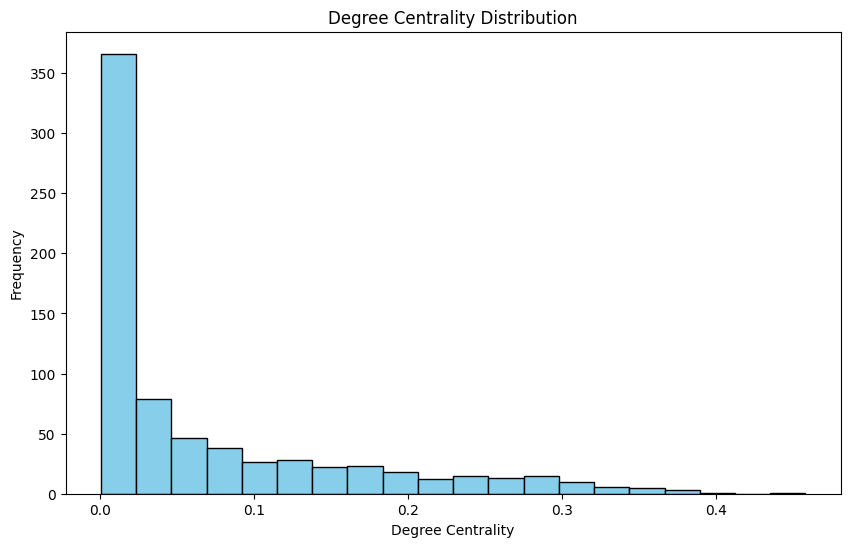

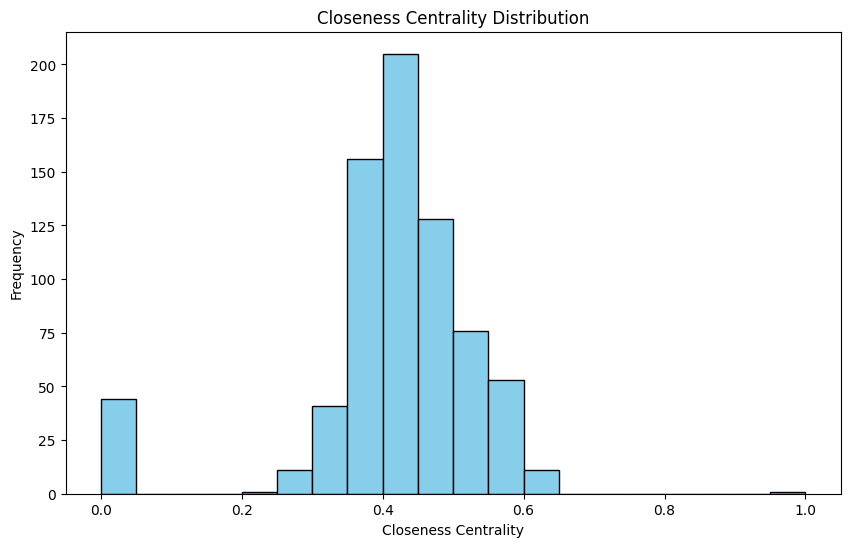

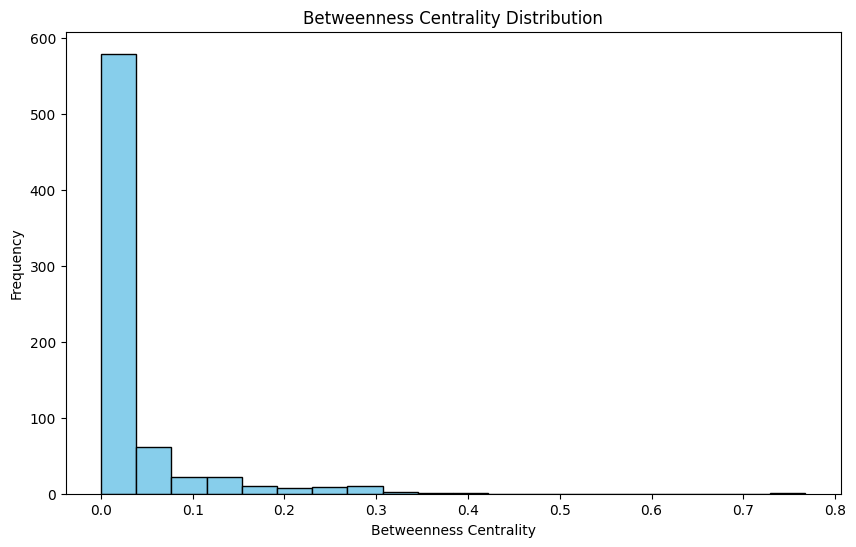

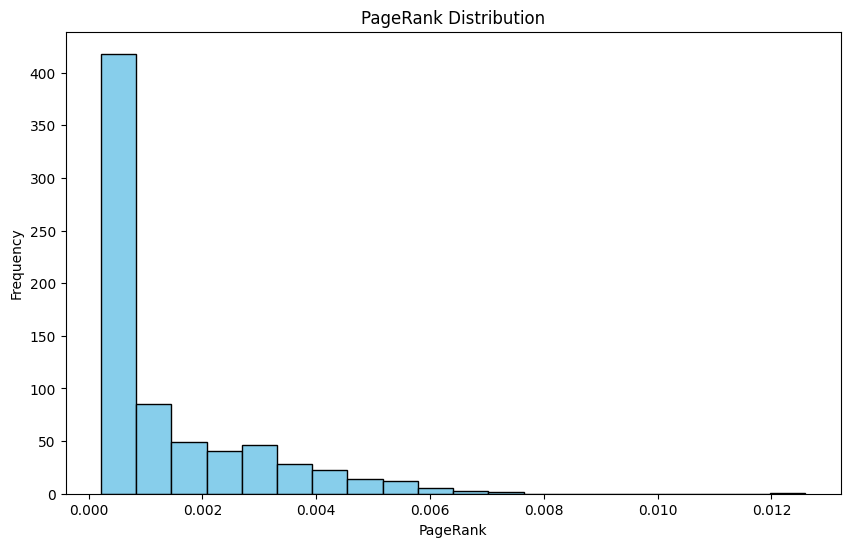

{'top_degree': [['YIP', 0.45798898071625344],
  ['MSP', 0.4015151515151515],
  ['MEM', 0.3884297520661157],
  ['MCI', 0.3712121212121212],
  ['ATL', 0.3712121212121212]],
 'top_closeness': [['FVS', 1.0],
  ['YIP', 0.643312101910828],
  ['MSP', 0.6229074889867842],
  ['MEM', 0.6190893169877408],
  ['ORD', 0.6185476815398075]],
 'top_betweenness': [['YIP', 0.7676223045502042],
  ['MSP', 0.3985636933599316],
  ['SHV', 0.3686843355181913],
  ['MCI', 0.3453443526170799],
  ['MEM', 0.33691840030398024]],
 'top_pagerank': [['YIP', 0.012596739235285695],
  ['SHV', 0.0075766713087627195],
  ['MSP', 0.007489817524955051],
  ['MEM', 0.006988517029806561],
  ['MCI', 0.006970352425966445]]}

In [18]:
results = compare_centralities(flight_network)
results

### Querying an LLM for Additional Centrality Measures

We asked ChatGPT to suggest other centrality measures that could be relevant. 
For instance, ChatGPT might suggest:
- **Eigenvector Centrality**
- **Katz Centrality**
- **HITS (Hub/Authority)**

How do we verify these suggestions?
- **Check academic references**: e.g., look up known measures in standard textbooks or scientific publications.
- **Compare** with well-documented libraries (e.g., `networkx.algorithms.centrality`).
- **Test** them on small or known networks for sanity checks.

### Trustworthiness of LLM Results

To ensure the suggestions are trustable, we:
- Compare them against widely accepted measures documented in `networkx`.
- Validate definitions match known formulas.
- For any major decisions, confirm results with domain experts or well-known references (e.g., academic papers).

### Implementing Eigenvector Centrality

We will implement a simple wrapper around NetworkX's `nx.eigenvector_centrality` for demonstration.

In [19]:
def calculate_eigenvector_centrality(flight_network, max_iter=100, tol=1e-06):
    """
    Calculate Eigenvector Centrality for all nodes in the flight_network using NetworkX's built-in function.
    """
    return nx.eigenvector_centrality(flight_network, max_iter=max_iter, tol=tol)

# Calculate and compare
eigen_centrality_dict = calculate_eigenvector_centrality(flight_network)

# Turn into a DataFrame for easy comparison
eigen_df = pd.DataFrame({
    'Airport': list(eigen_centrality_dict.keys()),
    'EigenvectorCentrality': list(eigen_centrality_dict.values())
})

eigen_df.sort_values(by='EigenvectorCentrality', ascending=False).head(10)

,Airport,EigenvectorCentrality
104,MSP,0.106748
131,MEM,0.105694
136,IND,0.102812
128,STL,0.102692
183,ATL,0.102676
100,MCI,0.101431
196,YIP,0.099491
119,ORD,0.099218
33,DFW,0.098503
51,OKC,0.096784


### Analysis of Eigenvector Centrality

Here, we compare the top airports identified by Eigenvector Centrality with other measures. 
Does it add new insights into the most "influential" nodes in the network?

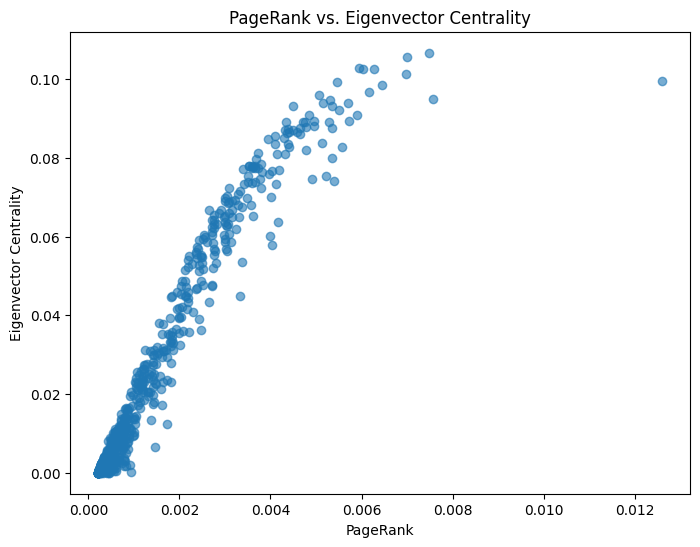

In [20]:
# For a quick correlation check with PageRank, for instance:
pagerank_values = []
eigen_values = []

for airport in flight_network.nodes():
    pagerank_values.append(calculate_page_rank(flight_network, airport))
    eigen_values.append(eigen_centrality_dict[airport])

# Create a simple scatter plot
plt.figure(figsize=(8,6))
plt.scatter(pagerank_values, eigen_values, alpha=0.6)
plt.title("PageRank vs. Eigenvector Centrality")
plt.xlabel("PageRank")
plt.ylabel("Eigenvector Centrality")
plt.show()

## **2. Nodes' Contribution (Q2)**

*In any network, certain nodes (airports, in this case) play a critical role in maintaining connectivity and flow. Centrality measures are used to identify these nodes.*

**Your Task:**
Implement a function analyze_centrality(flight_network, airport) that computes the following centrality measures for a given airport:

- Betweenness centrality: Measures how often a node appears on the shortest paths between other nodes.
- Closeness centrality: Measures how easily a node can access all other nodes in the network.
- Degree centrality: Simply counts the number of direct connections to the node.
- PageRank: Computes the "importance" of a node based on incoming connections and their weights.

Write a function compare_centralities(flight_network) to:

- Compute and compare centrality values for all nodes in the graph.
- Plot centrality distributions (histograms for each centrality measure).
- Return the top 5 airports for each centrality measure.
- Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

In [21]:
from funtions2.function2 import analyze_centrality, check_flight_data, compare_centralities , compare_centralities_with_checks,  compute_degree_centrality, compute_closeness_centrality,brandes_betweenness_all_nodes,  compute_betweenness_for_node, compute_pagerank_all,  compute_pagerank_for_node 

### **Explanation of Centrality Measures**

1. **Betweenness Centrality**  
2. **Closeness Centrality**  
3. **Degree Centrality**  
4. **PageRank** (not detailed below, but also widely used)

### Betweenness Centrality

### Definition

Betweenness centrality measures how often a node lies on the shortest paths between other nodes in a graph. It quantifies the importance of a node in controlling communication or flow within a network.

### Mathematical Formula

For a node $ v $, betweenness centrality is given by:

$$
C_B(v) \;=\; \sum_{s \neq v \neq t} \; \frac{\sigma_{s,t}(v)}{\sigma_{s,t}}
$$

Where:
- $ \sigma_{s,t} $ is the total number of shortest paths from node $ s $ to node $ t $.
- $ \sigma_{s,t}(v) $ is the number of those shortest paths that pass through $ v $.

### Steps to Compute Betweenness Centrality
1. **Identify all shortest paths**: For each pair of nodes $ s $ and $ t $ in the network, compute the shortest paths between them.
2. **Count path usage**: Determine how many of these shortest paths pass through the node $ v $.
3. **Sum fractions**: For all pairs $(s, t)$, add up the fraction $\frac{\sigma_{s,t}(v)}{\sigma_{s,t}}$. This yields the betweenness centrality of $ v $.


In [36]:
help(brandes_betweenness_all_nodes)
help(compute_betweenness_for_node)

Help on function brandes_betweenness_all_nodes in module funtions2.function2:

brandes_betweenness_all_nodes(graph)
    Use Brandes' algorithm to compute betweenness centrality for every node in a directed,
    unweighted graph. Returns a dict {node: betweenness_value}.
    
    The Betweenness Centrality of a node v is roughly how many shortest paths between other pairs
    (s, t) pass through v. Brandes' method does BFS from each node and back-propagates dependencies.

Help on function compute_betweenness_for_node in module funtions2.function2:

compute_betweenness_for_node(graph, airport)
    Compute Brandes betweenness centrality for all nodes, then return it
    for the single specified 'airport'.



### **Degree Centrality**

##### *Definition*

Degree centrality is the simplest centrality measure: it counts the number of direct connections (edges) a node has to other nodes in the network.

##### *Mathematical Formula*

For a node $ v $, degree centrality is:

$$
C_D(v) \;=\; \mathrm{degree}(v)
$$

Where:
- $\mathrm{degree}(v)$ is the number of edges connected to node $v$.

In a **directed** network, one often considers two types of degrees:
- **In-degree**: Number of edges (connections) pointing *into* $ v $.
- **Out-degree**: Number of edges (connections) going *out of* $ v $.

##### *Steps to Compute Degree Centrality*
1. **Count neighbors**: For undirected networks, simply count the edges of $ v $.  
2. **Directed case**: For directed networks, the degree can be split into in-degree and out-degree, or summed to get the total degree (in + out).

---


In [73]:
help(compute_degree_centrality)

Help on function compute_degree_centrality in module funtions2.function2:

compute_degree_centrality(graph, airport)
    Compute the degree centrality for a single 'airport'.
    
    Degree Centrality(airport) = in_degree(airport) + out_degree(airport)
    
    - out_degree(airport) is simply the length of graph[airport].
    - in_degree(airport) is the number of adjacency lists that include 'airport'.




### **Closeness Centrality**

#####  *Definition*

Closeness centrality measures how "close" a node is to all other nodes in the network. It is based on the total distance from the node to every other node.

##### *Mathematical Formula*

For a node $ v $, closeness centrality is often defined as the reciprocal of the sum of shortest path distances from $ v $ to all other nodes:

$$
C_C(v) \;=\; \frac{1}{\sum_{u \in V} d(v, u)}
$$

Where:
- $ d(v, u) $ is the shortest path distance from node $ v $ to node $ u $.
- $ V $ is the set of all nodes in the graph.

##### *Steps to Compute Closeness Centrality*
1. **Compute distances**: For a given node $ v $, compute the shortest distance to every other node $u$.
2. **Sum distances**: Add these distances up into a total $ \sum_{u} d(v, u) $.
3. **Take the reciprocal**: Closeness centrality is $ 1 \;/\; \text{(total distances)} $. A smaller sum of distances yields a larger closeness score, meaning the node is more central.


In [75]:
help(compute_closeness_centrality)

Help on function compute_closeness_centrality in module funtions2.function2:

compute_closeness_centrality(graph, airport)
    Closeness Centrality(airport) = (# reachable nodes) / (sum of distances to reachable nodes).
    
    - We first do a BFS to get the distance from 'airport' to every other node.
    - We ignore any node that is unreachable (distance = inf).
    - If no nodes are reachable, closeness is 0.



### **Explanation of PageRank**


### **Definition**

PageRank is a centrality measure that assigns a score to each node in a directed graph, representing the importance of the node based on the structure of incoming and outgoing edges. It was originally developed to rank web pages in Google's search engine.

PageRank assumes that a link (edge) from one node to another is a vote of importance, and nodes that receive many links from important nodes are themselves considered important.



### **Mathematical Formula**

PageRank is calculated iteratively using the following formula:

$$
PR(v) = \frac{1 - \alpha}{N} + \alpha \sum_{u \in \text{In}(v)} \frac{PR(u)}{\text{OutDeg}(u)}
$$

Where:
- $ PR(v) $: PageRank of node $ v $.
- $ \alpha $: Damping factor (usually set to 0.85).
- $ N $: Total number of nodes in the graph.
- $ \text{In}(v) $: Set of nodes that have an edge pointing to $ v $.
- $ \text{OutDeg}(u) $: Out-degree of node $ u $ (number of edges leaving $ u $).
- $ \frac{1 - \alpha}{N} $: Teleportation term, which ensures that the algorithm does not get stuck in disconnected parts of the graph.


### **Steps to Compute PageRank**

1. **Initialization**:  
   - Assign an equal initial PageRank score to all nodes:  
     $$
     PR(v) = \frac{1}{N}, \quad \forall v \in V
     $$

2. **Iterative Update**:  
   - Recalculate the PageRank of each node $ v $ based on the formula:
     $$
     PR(v) = \frac{1 - \alpha}{N} + \alpha \sum_{u \in \text{In}(v)} \frac{PR(u)}{\text{OutDeg}(u)}
     $$

3. **Teleportation**:  
   - Add the teleportation term $ \frac{1 - \alpha}{N} $ to prevent dangling nodes (nodes with no outgoing edges) from affecting the calculation.

4. **Convergence**:  
   - Repeat the calculation until the change in PageRank scores between iterations is less than a specified threshold ($ tol $) or until the maximum number of iterations ($ max\_iter $) is reached.



### **Key Concepts**

- **Damping Factor ($ \alpha $)**:  
  - The damping factor represents the probability that a "random surfer" follows an outgoing edge from a node. With probability $ 1 - \alpha $, the surfer teleports to a random node.
  - A typical value for $ \alpha $ is 0.85.

- **Dangling Nodes**:  
  - Nodes with no outgoing edges can distort the calculation. PageRank handles this by redistributing their rank equally among all nodes or using the teleportation mechanism.

- **Convergence**:  
  - The algorithm iteratively updates the PageRank scores until they stabilize. Convergence is achieved when the difference between scores in successive iterations is below a predefined threshold.



### **Practical Applications**

- **Web Search**:  
  - PageRank was originally used to rank web pages based on the importance of incoming links.

- **Social Networks**:  
  - Identify influential nodes in social or communication networks.

- **Transportation Networks**:  
  - Analyze the importance of airports or cities based on connectivity and flow.

- **Recommendation Systems**:  
  - Rank items or users based on interaction graphs.

By understanding and applying PageRank, you can effectively analyze the importance of nodes in a wide range of networks.

---

### **References**

1. Page, L., Brin, S., Motwani, R., & Winograd, T. (1999). *The PageRank Citation Ranking: Bringing Order to the Web*. Stanford InfoLab.  
   [Available Here](http://ilpubs.stanford.edu:8090/422/)

2. Langville, A. N., & Meyer, C. D. (2012). *Google's PageRank and Beyond: The Science of Search Engine Rankings*. Princeton University Press.

3. Kleinberg, J. (1999). *Authoritative sources in a hyperlinked environment*. Journal of the ACM, 46(5), 604–632.

4. Newman, M. E. J. (2010). *Networks: An Introduction*. Oxford University Press.


In [37]:
help(compute_pagerank_all)
help(compute_pagerank_for_node)

Help on function compute_pagerank_all in module funtions2.function2:

compute_pagerank_all(graph, alpha=0.85, max_iter=100, tol=1e-06)
    Calculate PageRank for all nodes in a directed, unweighted graph.
    - alpha: damping factor (0.85 is typical).
    - max_iter: max number of power-iteration steps.
    - tol: minimum difference threshold for convergence.
    Returns a dict {node: pagerank_value}.

Help on function compute_pagerank_for_node in module funtions2.function2:

compute_pagerank_for_node(graph, airport)
    Compute PageRank for all nodes, then return the value for the given 'airport'.




### **Comparing Centrality Measures**

When you have computed betweenness, closeness, and degree centralities (and optionally PageRank), you may want to compare them to see how differently nodes rank in importance. Some tips for comparison:

1. **Normalization**: Centrality values can be normalized to compare across networks of different sizes.  
2. **Visualizations**: Histograms or scatter plots can help identify whether certain nodes consistently rank high in multiple measures or if different measures yield very different rankings.  
3. **Interpretation**: 
   - **Betweenness** highlights nodes that act as "bridges" in shortest paths.  
   - **Closeness** emphasizes nodes that can quickly reach many others.  
   - **Degree** highlights the most directly connected nodes.  
   - **PageRank** (if used) factors in recursive influence based on how many important neighbors point to a node.

---

### General Notes

- **Graph Representation**: Your network is represented with nodes as airports and directed edges as flights.  
- **Shortest Paths**: For betweenness and closeness, you need shortest path computations. In unweighted graphs, a Breadth-First Search (BFS) from each node can suffice to find shortest paths.  
- **Directed vs. Undirected**: Always clarify if your network is directed. In this case, flights are directional (origin to destination).  
- **Practical Use**: 
  - **Betweenness** is often used to find critical intermediaries.  
  - **Closeness** is useful to find hubs that can reach others quickly.  
  - **Degree** identifies major connection points.  
  - **PageRank** can highlight nodes with higher "authority" in a network.

In [38]:
help(analyze_centrality)
help(compare_centralities)

Help on function analyze_centrality in module funtions2.function2:

analyze_centrality(df, airport)
    Build the directed graph from 'df' using 'build_directed_graph'.
    Then compute the following for a single 'airport':
       - Degree Centrality
       - Closeness Centrality
       - Betweenness Centrality
       - PageRank
    Returns a dict with these 4 measures for 'airport'.

Help on function compare_centralities in module funtions2.function2:

compare_centralities(df)
    1) Build the directed flight graph from 'df'.
    2) Compute:
       - Degree (in+out)
       - Closeness (BFS)
       - Betweenness (Brandes)
       - PageRank (iterative)
       for ALL nodes in the graph.
    3) Plot each distribution as a histogram.
    4) Return the top-5 airports for each metric in a dictionary.



{'airport': 'ATL', 'degree_centrality': 262123, 'closeness_centrality': 0.6121212121212121, 'betweenness_centrality': 27200.7925119757, 'pagerank': 0.029065264885572033}


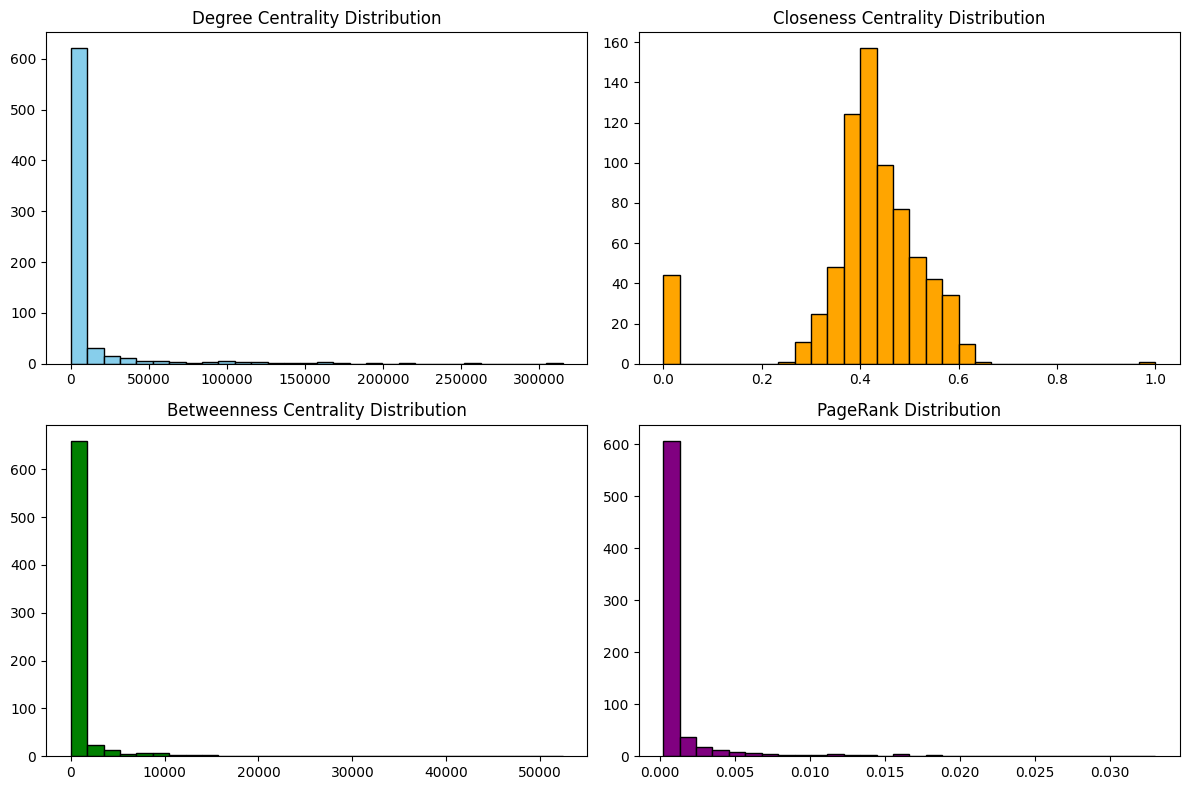

Top 5 (Degree): [('ORD', 314967), ('ATL', 262123), ('DFW', 215035), ('DTW', 198464), ('MSP', 196598)]
Top 5 (Closeness): [('FVS', 1.0), ('YIP', 0.643312101910828), ('MSP', 0.6229074889867842), ('MEM', 0.6190893169877408), ('ORD', 0.6185476815398075)]
Top 5 (Betweenness): [('YIP', 52415.847896743486), ('MSP', 32763.24878593967), ('ATL', 27200.7925119757), ('DFW', 25428.172958883737), ('ORD', 21905.164512801115)]
Top 5 (PageRank): [('ORD', 0.03300881422988194), ('ATL', 0.029065264885572033), ('DFW', 0.027458579491808313), ('MSP', 0.024561360948403062), ('DTW', 0.020657970147575574)]


In [42]:
# Suppose we have a DataFrame 'df' with columns:
#   Origin_airport, Destination_airport, ...
#   e.g. from a CSV or other source.

# 1) Single node's centralities
airport_centrality = analyze_centrality(df, "ATL")
print(airport_centrality)
# e.g. {
#   'airport': 'ATL',
#   'degree_centrality': 123,
#   'closeness_centrality': 0.0123,
#   'betweenness_centrality': 456.78,
#   'pagerank': 0.0009
# }

# 2) Compare all
results = compare_centralities(df)
print("Top 5 (Degree):",       results["top_degree"])
print("Top 5 (Closeness):",    results["top_closeness"])
print("Top 5 (Betweenness):",  results["top_betweenness"])
print("Top 5 (PageRank):",     results["top_pagerank"])

===debugging on flight dataframe===
 - Found 6068 rows where Origin == Destination (self-loops).
Procedi con cautela, potresti voler 'ripulire' i dati.


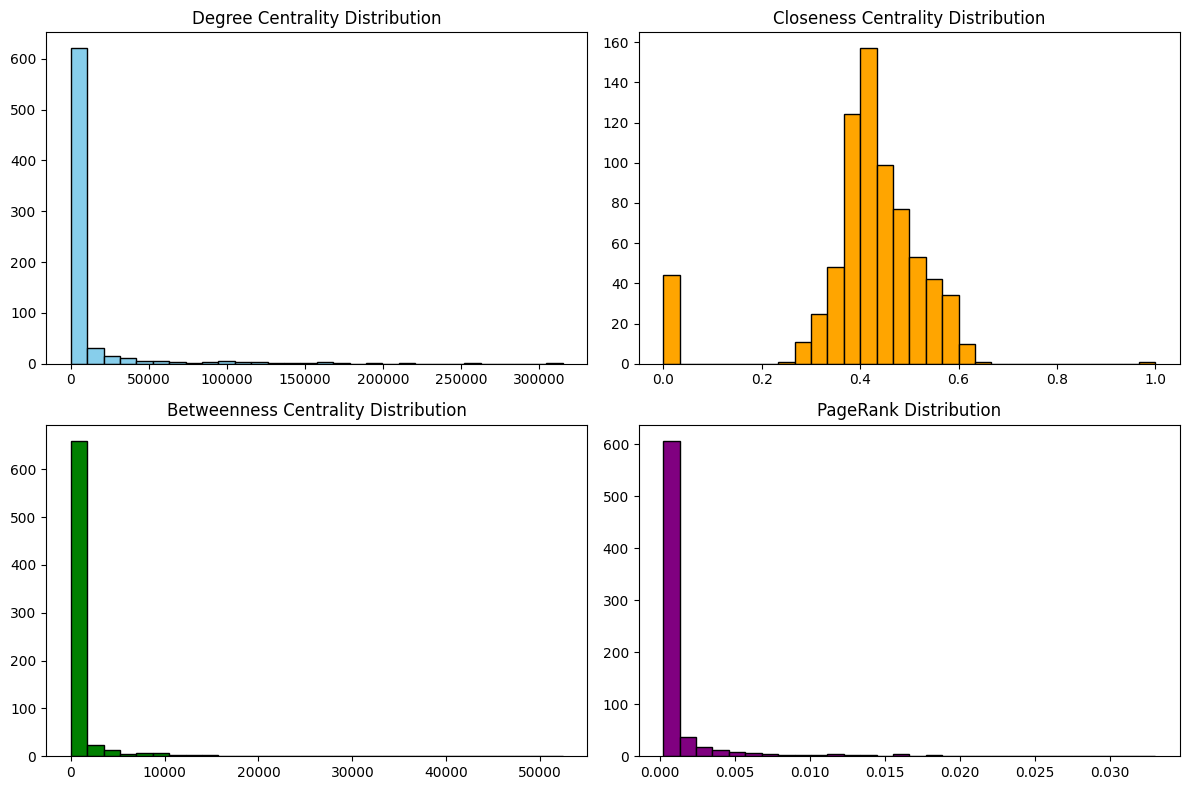


--- Top 5 (Degree) ---
[('ORD', 314967), ('ATL', 262123), ('DFW', 215035), ('DTW', 198464), ('MSP', 196598)]
--- Top 5 (Closeness) ---
[('FVS', 1.0), ('YIP', 0.643312101910828), ('MSP', 0.6229074889867842), ('MEM', 0.6190893169877408), ('ORD', 0.6185476815398075)]
--- Top 5 (Betweenness) ---
[('YIP', 52415.847896743486), ('MSP', 32763.24878593967), ('ATL', 27200.7925119757), ('DFW', 25428.172958883737), ('ORD', 21905.164512801115)]
--- Top 5 (PageRank) ---
[('ORD', 0.03300881422988194), ('ATL', 0.029065264885572033), ('DFW', 0.027458579491808313), ('MSP', 0.024561360948403062), ('DTW', 0.020657970147575574)]

=== anomalies in centrality measure  ===
 - [CLOSENESS] FVS = 1.0000 (Suspiciously high)
 - [BETWEENNESS] SEA = 17056.33 (> 3 std from mean)
 - [BETWEENNESS] PHX = 13026.52 (> 3 std from mean)
 - [BETWEENNESS] DFW = 25428.17 (> 3 std from mean)
 - [BETWEENNESS] SLC = 12255.74 (> 3 std from mean)
 - [BETWEENNESS] ABQ = 13709.44 (> 3 std from mean)
 - [BETWEENNESS] MCI = 14984.60 (

In [44]:
# 1) Check firstly the dataframe
data_issues = check_flight_data(df)
if data_issues:
    print("===debugging on flight dataframe===")
    for problem in data_issues:
        print(" -", problem)
    print("Procedi con cautela, potresti voler 'ripulire' i dati.")
else:
    print("Nessun problema macroscopico nel DataFrame (duplicati, missing, etc.).")

# 2) check issue / anomalies 
res_compare = compare_centralities_with_checks(df)

print("\n--- Top 5 (Degree) ---")
print(res_compare["top_degree"])
print("--- Top 5 (Closeness) ---")
print(res_compare["top_closeness"])
print("--- Top 5 (Betweenness) ---")
print(res_compare["top_betweenness"])
print("--- Top 5 (PageRank) ---")
print(res_compare["top_pagerank"])

if res_compare["anomalies"]:
    print("\n=== anomalies in centrality measure  ===")
    for a in res_compare["anomalies"]:
        print(" -", a)
else:
    print("\nNo anomaly in centrality measure ===")

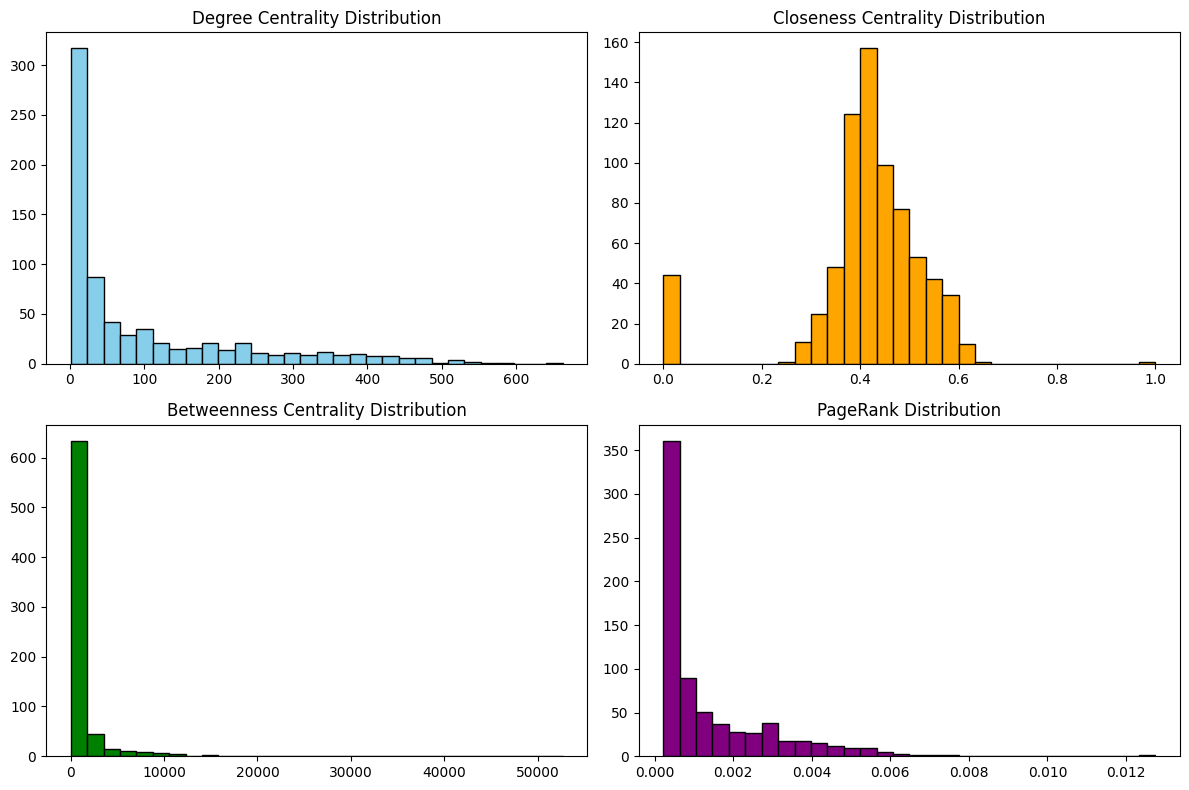

In [45]:
# drop all duplicates 
df_clean = df.drop_duplicates()

# 2) delete self-loop
df_clean = df_clean[df_clean['Origin_airport'] != df_clean['Destination_airport']]

# 3) Aggregates routes by joining multiples on different dates.  
df_clean = (
    df_clean
    .groupby(['Origin_airport', 'Destination_airport'], as_index=False)
    .agg({
        'Passengers': 'sum', 
        'Seats': 'sum', 
        'Flights': 'sum', 
        'Distance': 'mean'
        
    })
)

# 5) run compare_centralities_with_checks
res_compare = compare_centralities(df_clean)

### FUNCTION TO CHECK EVENTUALY ANOMALIES ••

In [46]:
from funtions2.function2 import check_flight_data

In [47]:
help(check_flight_data)

Help on function check_flight_data in module funtions2.function2:

check_flight_data(df)
    Perform basic checks on the flight DataFrame:
      1) Check for fully duplicated rows.
      2) Identify any rows where Origin_airport == Destination_airport (self-loops).
      3) Check for missing (NaN) values in 'Origin_airport' or 'Destination_airport'.
      4) (Optional) Flag suspicious IATA codes based on their length (<3 or >4 characters).
    
    Returns:
        list of strings describing any problems found.



In [48]:
df_problems = check_flight_data(df)
if df_problems:
    print("=== PROBLEM IN DATAFRAME===")
    for p in df_problems:
        print(" -", p)
else:
    print("No problem in dataframe.")


=== PROBLEM IN DATAFRAME===
 - Found 6068 rows where Origin == Destination (self-loops).


## Calculation of Centralities and Checking for Outliers.
After calculating all centralities (Degree, Closeness, Betweenness, PageRank) for all nodes, let's check for any outliers:

Closeness = 1.0 (or > 0.9, your choice) is very rare in a real flight network.
Much higher than average values in Betweenness. E.g., if an airport exceeds the average by 3-4 standard deviations.
Ditto on PageRank (though here it rarely gets to 1.0, usually < 0.05 in large networks, but you might have outliers in small network).

Translated with DeepL.com (free version)

## Integration with compare_centralities.
After calculating the 4 centralities, we can do the check:

In [49]:
from funtions2.function2 import detect_centrality_anomalies, compare_centralities_with_checks, detect_centrality_anomalies

In [50]:
help(detect_centrality_anomalies)

Help on function detect_centrality_anomalies in module funtions2.function2:

detect_centrality_anomalies(degree_dict, closeness_dict, betweenness_dict, pagerank_dict)
    Examine the four centrality dictionaries and detect possible outliers.
    
    Returns a list of textual warnings for nodes that exceed certain thresholds, e.g.:
      - closeness >= 0.9999
      - betweenness / pagerank / degree > mean + 3*std



In [51]:
help(compare_centralities_with_checks)

Help on function compare_centralities_with_checks in module funtions2.function2:

compare_centralities_with_checks(df)
    Extended version of a typical "compare_centralities":
      - Build a directed graph from df.
      - Compute the four measures (Degree, Closeness, Betweenness, PageRank) for all nodes.
      - Plot their distributions in histograms.
      - Return the top-5 nodes for each measure.
      - Also run anomaly checks (detect_centrality_anomalies) to flag potential outliers.
    
    Returns a dictionary with:
      {
        "top_degree": [...],
        "top_closeness": [...],
        "top_betweenness": [...],
        "top_pagerank": [...],
        "anomalies": [list_of_anomalies]
      }



In [52]:
help(detect_centrality_anomalies)

Help on function detect_centrality_anomalies in module funtions2.function2:

detect_centrality_anomalies(degree_dict, closeness_dict, betweenness_dict, pagerank_dict)
    Examine the four centrality dictionaries and detect possible outliers.
    
    Returns a list of textual warnings for nodes that exceed certain thresholds, e.g.:
      - closeness >= 0.9999
      - betweenness / pagerank / degree > mean + 3*std



=== CHECK flight dataframe..... ===
 - Found 6068 rows where Origin == Destination (self-loops).
go ahead with caution .... you may clean some data !!! 


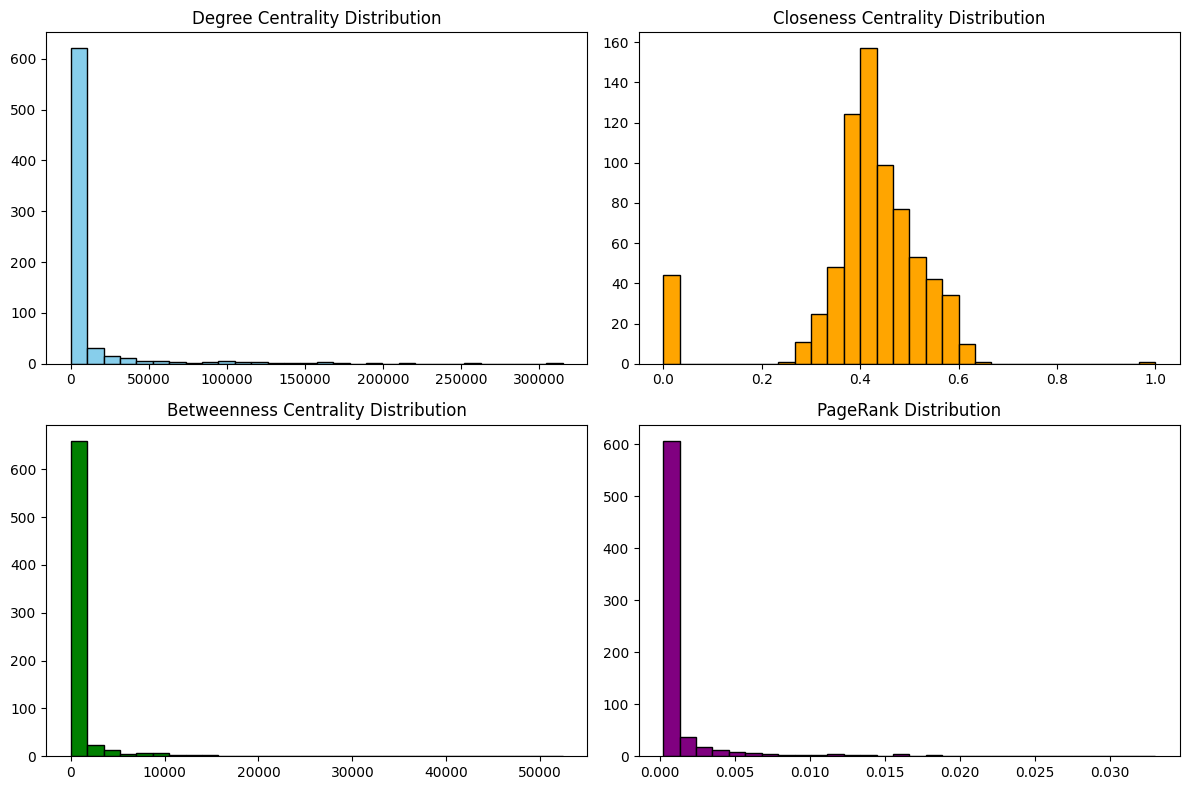


--- Top 5 (Degree) ---
[('ORD', 314967), ('ATL', 262123), ('DFW', 215035), ('DTW', 198464), ('MSP', 196598)]
--- Top 5 (Closeness) ---
[('FVS', 1.0), ('YIP', 0.643312101910828), ('MSP', 0.6229074889867842), ('MEM', 0.6190893169877408), ('ORD', 0.6185476815398075)]
--- Top 5 (Betweenness) ---
[('YIP', 52415.847896743486), ('MSP', 32763.24878593967), ('ATL', 27200.7925119757), ('DFW', 25428.172958883737), ('ORD', 21905.164512801115)]
--- Top 5 (PageRank) ---
[('ORD', 0.03300881422988194), ('ATL', 0.029065264885572033), ('DFW', 0.027458579491808313), ('MSP', 0.024561360948403062), ('DTW', 0.020657970147575574)]

=== Anomalies found in the df ===
 - [CLOSENESS] FVS = 1.0000 (Suspiciously high)
 - [BETWEENNESS] SEA = 17056.33 (> 3 std from mean)
 - [BETWEENNESS] PHX = 13026.52 (> 3 std from mean)
 - [BETWEENNESS] DFW = 25428.17 (> 3 std from mean)
 - [BETWEENNESS] SLC = 12255.74 (> 3 std from mean)
 - [BETWEENNESS] ABQ = 13709.44 (> 3 std from mean)
 - [BETWEENNESS] MCI = 14984.60 (> 3 std

In [54]:
# 1)check df 
data_issues = check_flight_data(df)
if data_issues:
    print("=== CHECK flight dataframe..... ===")
    for problem in data_issues:
        print(" -", problem)
    print("go ahead with caution .... you may clean some data !!! ")
else:
    print("No relevant problem found in the flight dataframe.")

# 2) doing again check 
res_compare = compare_centralities_with_checks(df)

print("\n--- Top 5 (Degree) ---")
print(res_compare["top_degree"])
print("--- Top 5 (Closeness) ---")
print(res_compare["top_closeness"])
print("--- Top 5 (Betweenness) ---")
print(res_compare["top_betweenness"])
print("--- Top 5 (PageRank) ---")
print(res_compare["top_pagerank"])

if res_compare["anomalies"]:
    print("\n=== Anomalies found in the df ===")
    for a in res_compare["anomalies"]:
        print(" -", a)
else:
    print("\nNo anomaies found in the df")

## dataset cleanup needed due to several incorencies :: 


In [ ]:
# 1) Remove total duplicates
df_clean = df.drop_duplicates()

# 2) Remove self-loops
df_clean = df_clean[df_clean['Origin_airport'] != df_clean['Destination_airport']]

# 3) (Optional) Aggregate routes by merging multiples on different dates
df_clean = (
    df_clean
    .groupby(['Origin_airport', 'Destination_airport'], as_index=False)
    .agg({
        'Passengers': 'sum', 
        'Seats': 'sum', 
        'Flights': 'sum', 
        'Distance': 'mean'
        # ... if you have other columns to aggregate
    })
)

# 4) Re-run checks and analyses
df_problems = check_flight_data(df_clean)
if df_problems:
    for p in df_problems:
        print(" -", p)
else:
    print("No major issues in the cleaned data.")

# 5) Run compare_centralities_with_checks
res_compare = compare_centralities_with_checks(df_clean)

# ... and so on



In [ ]:
res_compare = compare_centralities_with_checks(df_clean)


In [56]:
print("=== POST-CLEANING RESULTS ===")
print("\n--- Top 5 (Degree) ---")
print(res_compare["top_degree"])
print("--- Top 5 (Closeness) ---")
print(res_compare["top_closeness"])
print("--- Top 5 (Betweenness) ---")
print(res_compare["top_betweenness"])
print("--- Top 5 (PageRank) ---")
print(res_compare["top_pagerank"])

if res_compare["anomalies"]:
    print("\n=== Anomalies Detected in Centralities ===")
    for a in res_compare["anomalies"]:
        print(" -", a)
else:
    print("\nNo anomalies detected in the centrality metrics.")


=== POST-CLEANING RESULTS ===

--- Top 5 (Degree) ---
[('YIP', 663), ('MSP', 581), ('MEM', 562), ('ATL', 537), ('MCI', 537)]
--- Top 5 (Closeness) ---
[('FVS', 1.0), ('YIP', 0.643312101910828), ('MSP', 0.6229074889867842), ('MEM', 0.6190893169877408), ('ORD', 0.6185476815398075)]
--- Top 5 (Betweenness) ---
[('YIP', 52692.185173451544), ('MSP', 14567.363873580241), ('MEM', 14120.521429976758), ('MCI', 12697.602581183593), ('SHV', 11663.349550095149)]
--- Top 5 (PageRank) ---
[('YIP', 0.012747848534144731), ('SHV', 0.007666842304774863), ('MSP', 0.007601362519787647), ('MEM', 0.0070905187494729885), ('MCI', 0.0070710180188639634)]

=== Anomalies Detected in Centralities ===
 - [CLOSENESS] FVS = 1.0000 (Suspiciously high)
 - [BETWEENNESS] ATL = 10071.43 (> 3 std from mean)
 - [BETWEENNESS] IAD = 9863.21 (> 3 std from mean)
 - [BETWEENNESS] JFK = 9184.65 (> 3 std from mean)
 - [BETWEENNESS] MCI = 12697.60 (> 3 std from mean)
 - [BETWEENNESS] MEM = 14120.52 (> 3 std from mean)
 - [BETWEENN

In [57]:
df_fvs = df_clean[(df_clean["Origin_airport"] == "FVS") | (df_clean["Destination_airport"] == "FVS")]
df_yip = df_clean[(df_clean["Origin_airport"] == "YIP") | (df_clean["Destination_airport"] == "YIP")]

In [58]:
from funtions2.function2 import inspect_airport

# example
inspect_airport(df_clean, "FVS")
inspect_airport(df_clean, "YIP")


# example...
inspect_airport(df_clean, "FVS")
inspect_airport(df_clean, "YIP")



=== Inspection for Airport: FVS ===
Total rows found: 2
  - As Origin: 1 rows
  - Top 10 Destination_airport:
Destination_airport
BYI    1
Name: count, dtype: int64
  - As Destination: 1 rows
  - Top 10 Origin_airport:
Origin_airport
SLC    1
Name: count, dtype: int64
  - Average Passengers on routes involving FVS: 0.00
  - Average Flights on routes involving FVS: 6.00
  - Average Seats on routes involving FVS: 0.00

Example up to 5 rows:
      Origin_airport Destination_airport  Passengers  Seats  Flights  Distance
13123            FVS                 BYI           0      0        1     134.0
32593            SLC                 FVS           0      0       11     210.0

=== Inspection for Airport: YIP ===
Total rows found: 663
  - As Origin: 333 rows
  - Top 10 Destination_airport:
Destination_airport
ABE    1
MRC    1
MOT    1
MOR    1
MOP    1
MOB    1
MNN    1
MMI    1
MLU    1
MKL    1
Name: count, dtype: int64
  - As Destination: 330 rows
  - Top 10 Origin_airport:
Origin_airpo

In [59]:
help(inspect_airport)

Help on function inspect_airport in module funtions2.function2:

inspect_airport(df, airport_code)
    Inspect detailed statistics for a single airport (airport_code) within the DataFrame (df).
    Main actions:
      - Count total rows where this airport appears as either Origin or Destination.
      - List the most common destinations (if airport_code is in 'Origin_airport').
      - List the most common origins (if airport_code is in 'Destination_airport').
      - Show basic statistics on 'Passengers', 'Flights', 'Seats' columns, if available.
      - Print a small sample (head) of these rows.
    
    Parameters:
      df (pd.DataFrame): Flight DataFrame with columns like 'Origin_airport', 'Destination_airport', ...
      airport_code (str): The specific airport code to inspect.



In [60]:
from funtions2.function2 import summarize_routes, top_connections_for_airport, check_degree_from_dataframe

# Esempio d'uso
df_summary = summarize_routes(df_clean)
out_fvs, in_fvs = top_connections_for_airport(df_summary, "FVS", top=10)
print("=== Rotte in uscita da FVS ===")
print(out_fvs)
print("\n=== Rotte in entrata a FVS ===")
print(in_fvs)


=== Rotte in uscita da FVS ===
      Origin_airport Destination_airport  Passengers  Flights  Seats
13123            FVS                 BYI           0        1      0

=== Rotte in entrata a FVS ===
      Origin_airport Destination_airport  Passengers  Flights  Seats
32593            SLC                 FVS           0       11      0


In [61]:
help(top_connections_for_airport)

Help on function top_connections_for_airport in module funtions2.function2:

top_connections_for_airport(df_summary, airport_code, top=10)
    Given a summary DataFrame (df_summary) with columns ['Origin_airport','Destination_airport','Passengers','Flights','Seats'],
    extract the top (by 'Passengers') outgoing and incoming connections for 'airport_code'.
    
    Parameters:
      - df_summary (pd.DataFrame): Usually an aggregated DataFrame from `summarize_routes`.
      - airport_code (str): The specific airport to analyze connections for.
      - top (int): How many top routes to list (based on descending 'Passengers').
    
    Returns:
      (outgoing_sorted, incoming_sorted) DataFrames, each limited to 'top' rows, sorted by 'Passengers' descending.



In [62]:
help(summarize_routes)

Help on function summarize_routes in module funtions2.function2:

summarize_routes(df)
    Summarize the flight routes by grouping (Origin_airport, Destination_airport).
    
    Returns a DataFrame with aggregated stats, e.g.:
    - For each (Origin_airport, Destination_airport),
      sum of 'Passengers', 'Flights', 'Seats', etc.
    
    By default, it uses sum, but you can customize if you want average or other metrics.



In [63]:
help(check_degree_from_dataframe)

Help on function check_degree_from_dataframe in module funtions2.function2:

check_degree_from_dataframe(df_clean, airport_code)
    A quick check to see how many unique 'Destination_airport' and 'Origin_airport' connect to airport_code.
    
    This does not run BFS or compute formal in/out-degree from an adjacency list.
    It simply uses sets to count distinct routes in the DataFrame.
    
    Print:
      - how many unique destinations (airport_code -> ???)
      - how many unique origins (??? -> airport_code)
      - total (out + in) => might overlap if the same node is both a dest and an origin



In [64]:
# example 
check_degree_from_dataframe(df_clean, "YIP")
check_degree_from_dataframe(df_clean, "FVS")


=== Connections for YIP ===
Outgoing from YIP: 333 unique destinations.
Incoming to YIP: 330 unique origins.
Total degree (from sets) = 663 (note that overlap is possible).

=== Connections for FVS ===
Outgoing from FVS: 1 unique destinations.
Incoming to FVS: 1 unique origins.
Total degree (from sets) = 2 (note that overlap is possible).


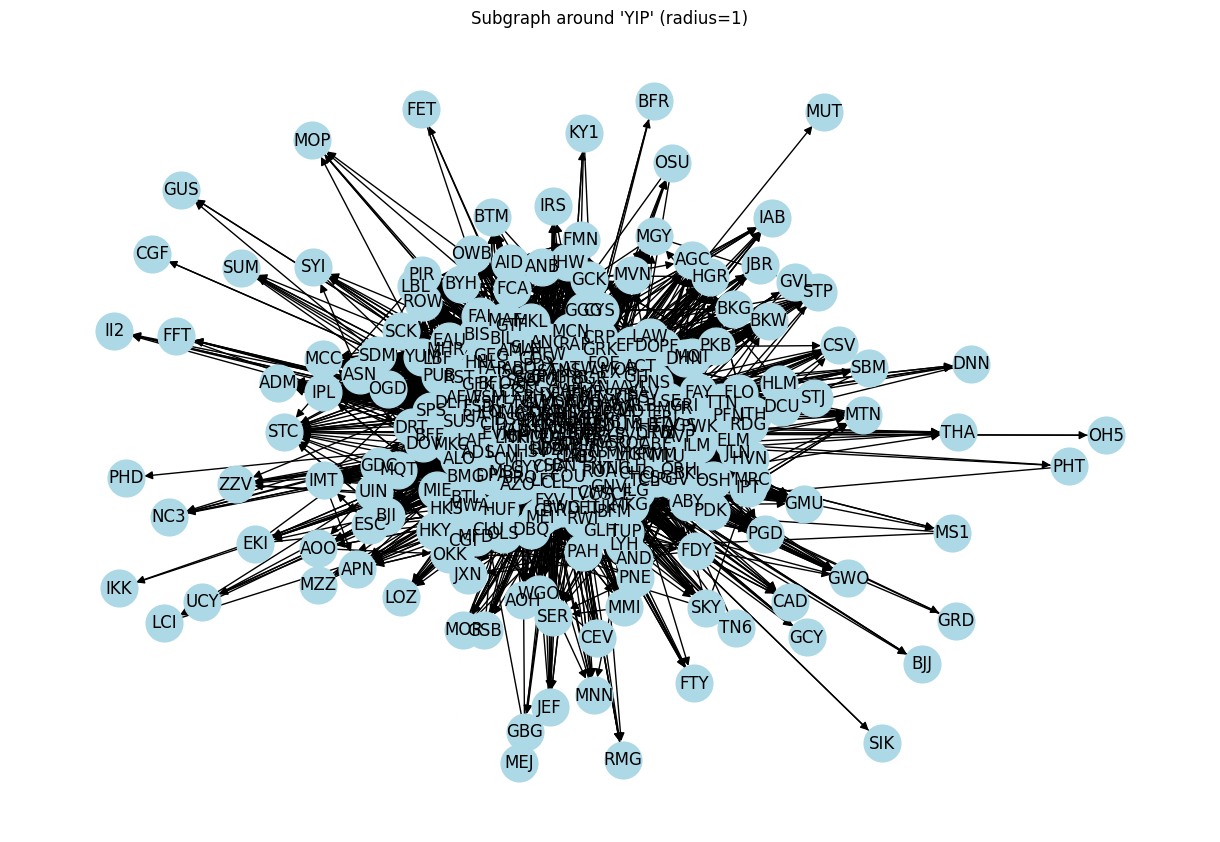

In [65]:
from funtions2.function2 import build_directed_graph_simple, extract_subgraph, visualize_subgraph

visualize_subgraph(df_clean, "YIP", radius=1)

In [66]:
from funtions2.function2 import detect_volume_outliers


# example: find outlier on passegers 
passenger_outliers = detect_volume_outliers(df_clean, column="Passengers", z_threshold=5)
print(f"rows  outlier on Passengers > 5-sigma: {len(passenger_outliers)}")
print(passenger_outliers.head(10))

rows  outlier on Passengers > 5-sigma: 328
     Origin_airport Destination_airport  Passengers     Seats  Flights  \
323             ABQ                 PHX    11271129  17191871   132240   
1659            ANC                 SEA    14299266  20939001   144754   
1845            ATL                 BOS    13092014  17794904   103310   
1852            ATL                 BWI    10010118  13621460    93453   
1866            ATL                 CLT     8586469  13640369   117148   
1881            ATL                 DCA    11557164  16633172   115585   
1884            ATL                 DFW    21626001  30066413   201850   
1889            ATL                 DTW     9948528  14768441   109746   
1899            ATL                 EWR    15023406  21506569   152753   
1906            ATL                 FLL    17212233  22281953   117237   

         Distance  
323    328.026070  
1659  1448.478774  
1845   946.000000  
1852   576.000000  
1866   227.000000  
1881   547.000000  
18

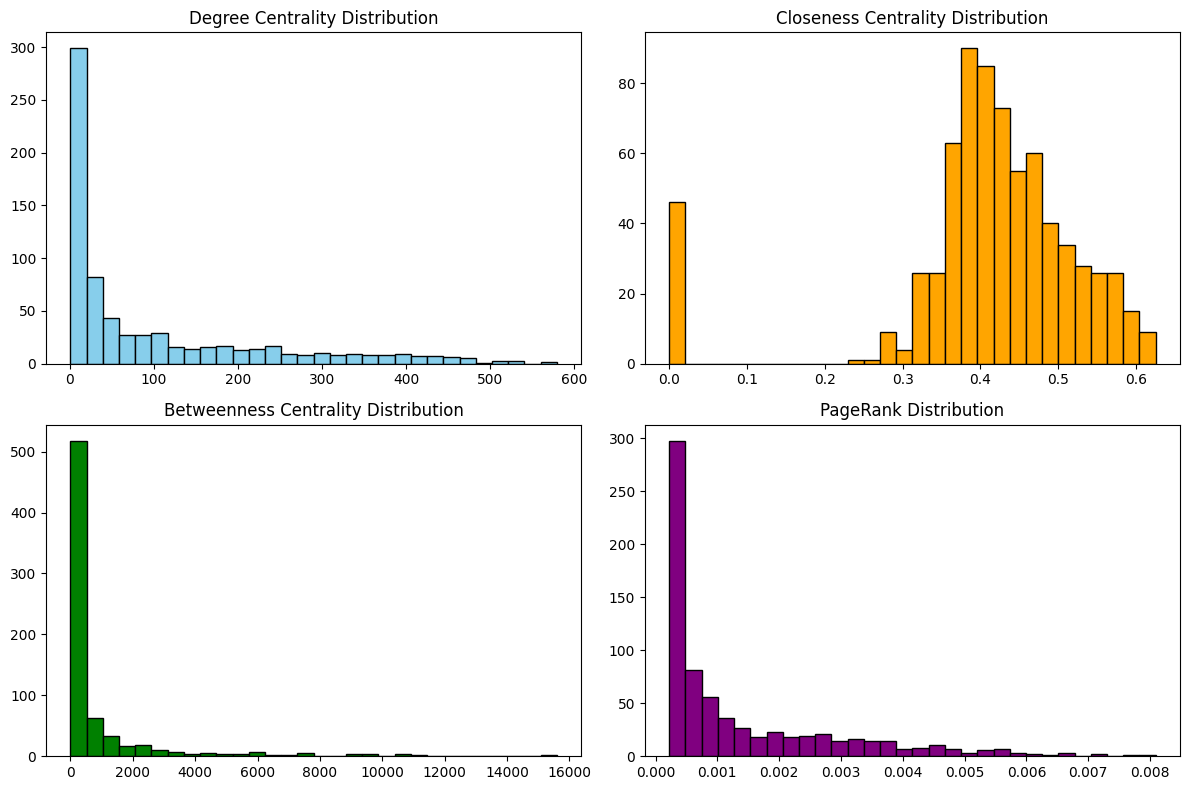

TOP 5 (Degree), without  FVS and YIP: [('MSP', 579), ('MEM', 560), ('ATL', 535), ('MCI', 535), ('ORD', 522)]


In [69]:
from funtions2.function2 import remove_suspicious_nodes


# for example exluding  FVS and YIP
df_no_fvs_yip = remove_suspicious_nodes(df_clean, ["FVS", "YIP"])

# restart analysis of cenrtrlities measures
res_compare_no_suspects = compare_centralities_with_checks(df_no_fvs_yip)
print("TOP 5 (Degree), without  FVS and YIP:", res_compare_no_suspects["top_degree"])

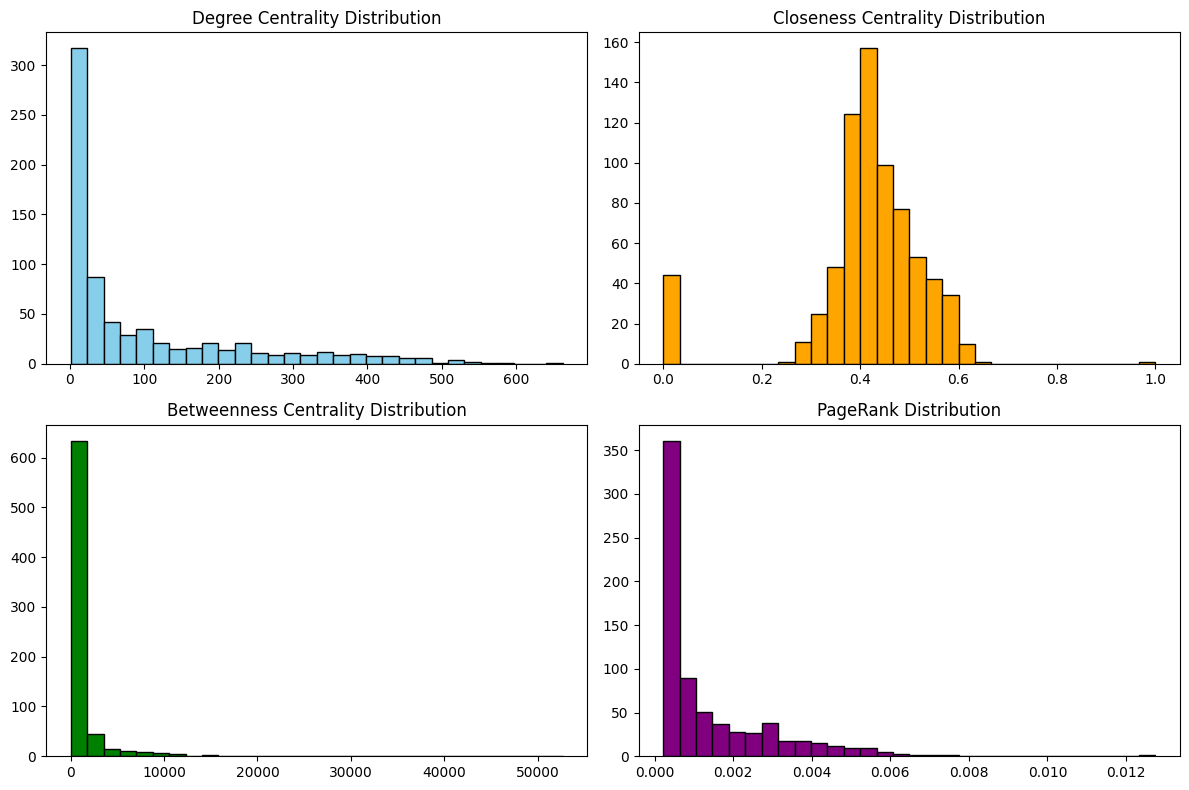

TOP 5 (Degree) [('YIP', 663), ('MSP', 581), ('MEM', 562), ('ATL', 537), ('MCI', 537)]


In [68]:
res_compare_no_suspects = compare_centralities_with_checks(df_clean)
print("TOP 5 (Degree)", res_compare_no_suspects["top_degree"])
# ... and go on ...

### Revised Analysis: Excluding Suspicious Nodes

To refine the analysis and focus on the overall structure of the network, we exclude suspicious nodes that may disproportionately affect centrality measures. Below is the revised process:

1. **Identify and Remove Suspicious Nodes**  
   Using the `remove_suspicious_nodes` function, nodes such as "FVS" and "YIP" are excluded from the dataset. These nodes exhibited unusually high centrality values, indicating potential anomalies or outliers.

2. **Recompute Centrality Measures**  
   After excluding these nodes, we recompute the centrality measures to analyze the remaining network structure more accurately.

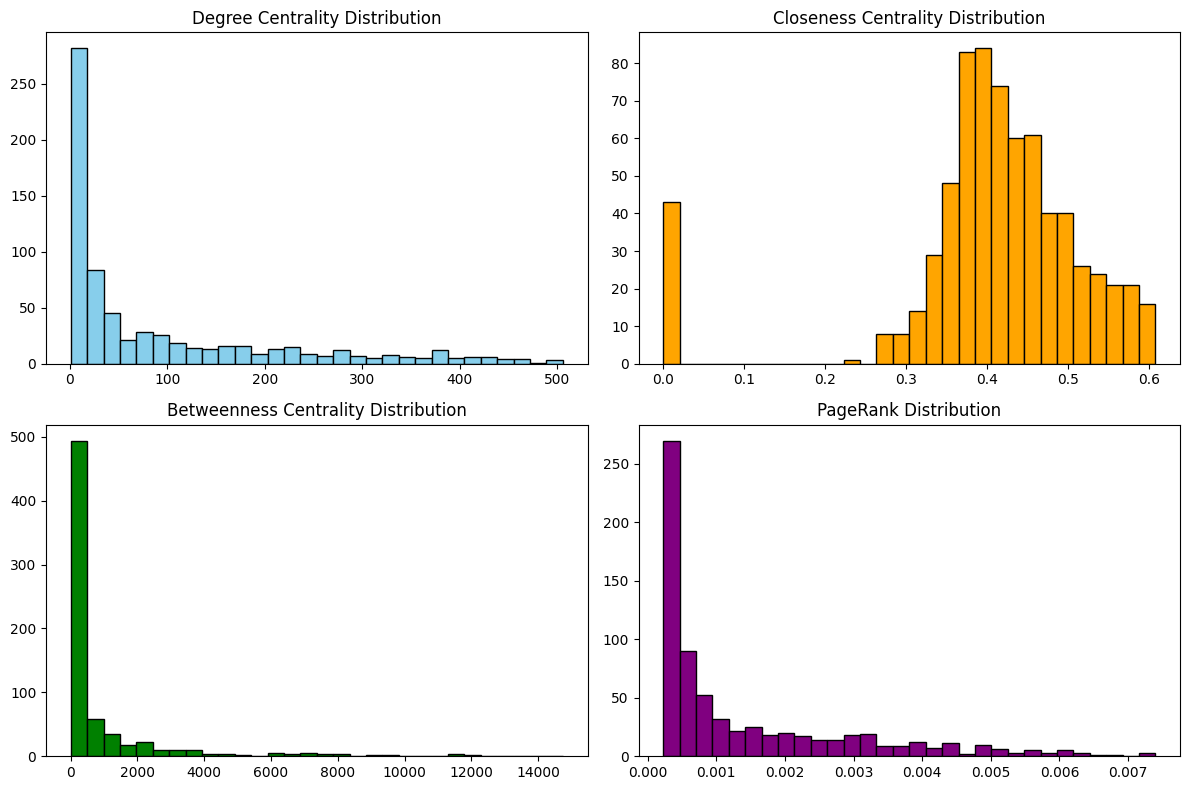

=== Revised Centrality Analysis (Excluding Top-Scored Airports) ===

--- Top 5 (Degree) ---
[('DFW', 506), ('STL', 505), ('IND', 497), ('MIA', 489), ('PHX', 468)]
--- Top 5 (Closeness) ---
[('DFW', 0.6079494128274616), ('MIA', 0.6063063063063063), ('STL', 0.6052158273381295), ('IND', 0.6046720575022462), ('PHX', 0.6003568242640499)]
--- Top 5 (Betweenness) ---
[('LRD', 14740.546230335334), ('DFW', 12379.66362230041), ('ELP', 12202.320574455118), ('MIA', 12046.279382331859), ('IAD', 11678.504903307992)]
--- Top 5 (PageRank) ---
[('OKC', 0.007397228937504532), ('DFW', 0.007170882422435075), ('STL', 0.007159347621672986), ('IND', 0.006744873084820906), ('MIA', 0.006506119094541341)]


In [72]:
# Define the top airports to exclude based on previous analysis
airports_to_exclude = ["YIP", "MSP", "MEM", "ATL", "MCI", "FVS", "ORD", "SHV"]

# Remove these airports from the dataset
df_filtered = remove_suspicious_nodes(df_clean, airports_to_exclude)

# Recompute the centrality measures on the filtered dataset
res_compare_filtered = compare_centralities_with_checks(df_filtered)

# Display the updated results
print("=== Revised Centrality Analysis (Excluding Top-Scored Airports) ===")
print("\n--- Top 5 (Degree) ---")
print(res_compare_filtered["top_degree"])
print("--- Top 5 (Closeness) ---")
print(res_compare_filtered["top_closeness"])
print("--- Top 5 (Betweenness) ---")
print(res_compare_filtered["top_betweenness"])
print("--- Top 5 (PageRank) ---")
print(res_compare_filtered["top_pagerank"])


In [ ]:
## part 6 :: BONUS ::


